In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def best_runs(file_paths, epochs):
    dataframes = []
    for i in range(len(file_paths)):
        with open(file_paths[i], 'r') as f:
            lines = f.readlines()

        records = [] 
        for line in lines:
            match = re.search(
                r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)", line
            )
            if match:
                mixing_ratio = float(match.group(1))
                learning_rate = float(match.group(2))
                val_loss = float(match.group(3))
                perplexity = float(match.group(4))
                records.append({
                    "mixing_ratio": mixing_ratio, 
                    "learning_rate": learning_rate,
                    "val_loss": val_loss,
                    "perplexity": perplexity
                })

        df = pd.DataFrame(records)
        df_best = df.loc[df.groupby("mixing_ratio")["val_loss"].idxmin()].reset_index(drop=True)
        df_best["experiment"] = f"{epochs[i]}"
        dataframes.append(df_best)

    return dataframes


In [2]:
def get_best_overall_runs(file_paths, epochs):
    best_rows = []

    for i in range(len(file_paths)):
        with open(file_paths[i], 'r') as f:
            lines = f.readlines()

        records = []
        for line in lines:
            match = re.search(
                r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)", line
            )
            if match:
                mixing_ratio = float(match.group(1))
                learning_rate = float(match.group(2))
                val_loss = float(match.group(3))
                records.append({
                    "mixing_ratio": mixing_ratio,
                    "learning_rate": learning_rate,
                    "val_loss": val_loss,
                    "experiment": epochs[i]
                })

        df = pd.DataFrame(records)
        best_row = df.loc[df["val_loss"].idxmin()]  # only the best run per configuration is retrieved
        best_rows.append(best_row)

    return pd.DataFrame(best_rows)

In [3]:
def plot_reg_and_repeat(iters_repeat, subsamples, model_params, iters_reg, legend_rep, legend_reg, epochs, hq_data, title_addition=None):
    
    # repeat aware
    file_paths = []
    for model in model_params:
        for i in range(len(iters_repeat)):
            file_paths.append(f"./summary_logs/{hq_data}/summary_{iters_repeat[i]}iter_{model}_{subsamples[i]}.txt")
    
    dfs = best_runs(file_paths, epochs)
    
    # Display each DataFrame
    '''for df in dfs:
        print(f"Dataframe for 1/{int(32 / int(df['experiment'].iloc[0]))}x {hq_data} (Repeat-Aware)")
        display(df.drop(columns=["experiment"]))'''
    
    plt.figure(figsize=(10, 6))
    legend_idx = 0
    
    for df in dfs:
        label = df["experiment"].iloc[0]
        # plot_label = f"{label}x Wikipedia"
        plot_label = f"{legend_rep[legend_idx]}"
        legend_idx += 1
    

        plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)

    # Scaling laws, non Repeat-Aware
    file_paths_reg = []
    #model_params = ["124M"]
    legend_idx = 0
    for model in model_params:
        for val in iter_values_reg:
            file_paths_reg.append(f"./summary_logs/{hq_data}/summary_{val}iter_{model}_1.txt")
            
    dfs_reg = best_runs(file_paths_reg, epochs)  
    for df in dfs_reg:
        label = df["experiment"].iloc[0]
        # plot_label = f"{label}x Wikipedia"
        plot_label = f"{legend_labels_reg[legend_idx]}"
        legend_idx += 1
    
        plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)

    # Display each DataFrame
    '''for df in dfs_reg:
        print(f"Dataframe for {df['experiment'].iloc[0]}x {hq_data}")
        display(df.drop(columns=["experiment"]))'''
    
    plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
    plt.ylabel("Validation Loss")
    if hq_data == "pubmed":
        plt.title(f"Validation Loss per Mixing Ratio Across Training Horizons for PubMed, {model_params[0]} Model")
    else:
        plt.title(f"Validation Loss per Mixing Ratio Across Training Horizons for Wikipedia, {model_params[0]} Model")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
   
    return file_paths, file_paths_reg, dfs, dfs_reg
    

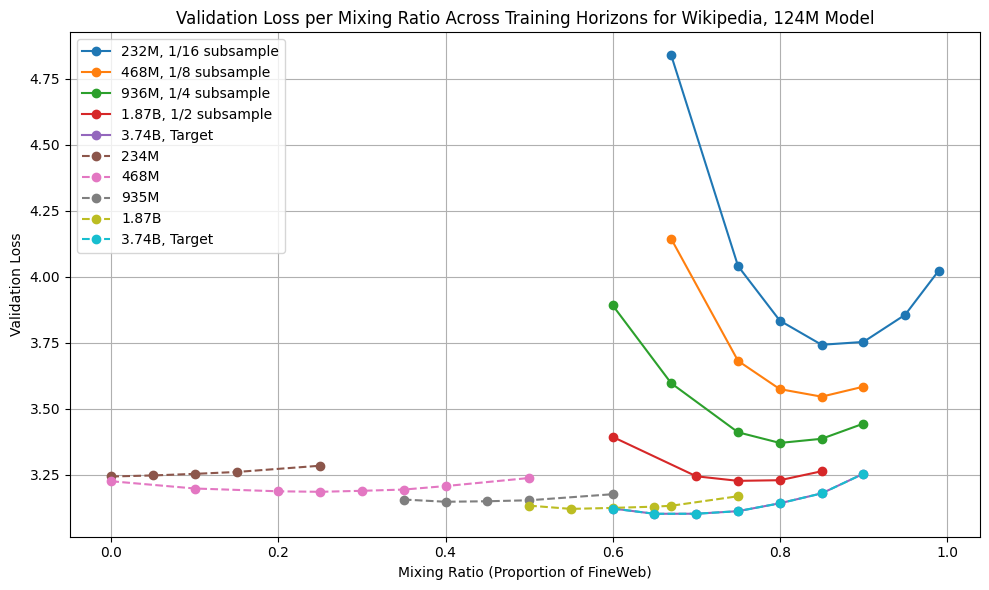

In [4]:
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["124M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B, Target"]
legend_labels_reg = ["234M", "468M", "935M", "1.87B", "3.74B, Target"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_124M, wiki_file_paths_reg_124M, dfs_repeat_wiki_124M, dfs_reg_wiki_124M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

In [5]:
# Actual Loss / Optimal Loss From Subsample Mixture Ratios 
for df in dfs_reg_wiki_124M:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

data = {
    'Subsample Used': ["1/16", "1/8", "1/4", "1/2"],
    'Loss / Optimal Loss on Target Horizon': [3.18/3.0998, 3.18/3.0998, 3.1425/3.0998, 3.1127/3.0998]
}
df = pd.DataFrame(data)
print(df)

Dataframe for 2x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00200,3.2440,25.6353
1,0.05,0.00141,3.2480,25.7389
2,0.10,0.00141,3.2540,25.8930
3,0.15,0.00200,3.2611,26.0791
4,0.25,0.00141,3.2848,26.7034


Dataframe for 4x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00141,3.2260,25.1783
1,0.10,0.00141,3.1985,24.4963
2,0.20,0.00141,3.1879,24.2386
3,0.25,0.00200,3.1860,24.1919
4,0.30,0.00141,3.1898,24.2839
5,0.35,0.00141,3.1945,24.3989
6,0.40,0.00141,3.2077,24.7222
7,0.50,0.00141,3.2383,25.4892


Dataframe for 8x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.35,0.00100,3.1567,23.4922
1,0.40,0.00141,3.1483,23.2967
2,0.45,0.00141,3.1502,23.3401
3,0.50,0.00141,3.1539,23.4262
4,0.60,0.00141,3.1769,23.9722


Dataframe for 16x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,3.1336,22.9574
1,0.55,0.001,3.1213,22.6757
2,0.60,0.001,3.1250,22.7601
3,0.65,0.001,3.1298,22.8691
4,0.67,0.001,3.1331,22.9452
5,0.75,0.001,3.1692,23.7883


Dataframe for 32x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.001,3.1227,22.7067
1,0.65,0.001,3.1027,22.2570
2,0.70,0.001,3.1029,22.2627
3,0.75,0.001,3.1127,22.4818
4,0.80,0.001,3.1425,23.1621
5,0.85,0.001,3.1800,24.0465
6,0.90,0.001,3.2545,25.9059


  Subsample Used  Loss / Optimal Loss on Target Horizon
0           1/16                               1.025873
1            1/8                               1.025873
2            1/4                               1.013775
3            1/2                               1.004162


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker

def mix_and_epochs(file_paths_lists, epochs, num_tokens,
                   params=("30M", "124M", "345M"),
                   colors=("blue", "red", "orange"),
                   title=None,
                   multiple=True,
                   repeat_aware=False,
                   repeat_aware_tokens=None,
                   smaller_legend=True):
    """ Plot the optimal epochs over training horizons. Allows different sets of experiments and model sizes to be passed in. """

    fig, ax = plt.subplots(figsize=(8, 5))
    coefs, intercepts = [], []
    all_tokens, all_epochs = [], []

    for idx, file_paths in enumerate(file_paths_lists):
        df_best = get_best_overall_runs(file_paths, epochs).copy()
        df_best["experiment"] = df_best["experiment"].astype(float)

        if repeat_aware:
            df_best["optimal_epochs"] = 32 * (1 - df_best["mixing_ratio"])
           
            df_best["tokens"] = df_best["experiment"].map(repeat_aware_tokens)
        else:
            df_best["optimal_epochs"] = df_best["experiment"] * (1 - df_best["mixing_ratio"])
        
            df_best["tokens"] = df_best["experiment"] * num_tokens

        df_best = df_best[(df_best["tokens"] > 0) & (df_best["optimal_epochs"] > 0)]
        if df_best.empty:
            continue

        X = df_best[["tokens"]].to_numpy(dtype=float)
        y = df_best["optimal_epochs"].to_numpy(dtype=float)

        all_tokens.extend(X.flatten().tolist())
        all_epochs.extend(y.tolist())

        # Linear regression
        reg = LinearRegression().fit(np.log(X), np.log(y))
        coefs.append(reg.coef_[0])
        intercepts.append(reg.intercept_)

        x_test = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
        y_pred = np.exp(reg.predict(np.log(x_test)))

        ax.scatter(X, y, color=colors[idx % len(colors)],
                   label=f"Best Mixing Ratio per Experiment ({params[idx % len(params)]})")
        ax.plot(x_test, y_pred, color=colors[idx % len(colors)],
                label=f"Line of Best Fit ({params[idx % len(params)]})")

    # make the axes log-scale
    ax.set_xscale("log")
    ax.set_yscale("log")

    if all_tokens:
        xticks = np.unique(np.array(all_tokens, dtype=float))
        xticks = xticks[xticks > 0]
        ax.set_xticks(xticks)

        def _fmt_x(x, pos):
            if not np.isfinite(x) or x <= 0:
                return ""
            s = f"{x:.2e}"  # '1.23e+09'
            return s.replace("e+0", "e").replace("e+", "e").replace("e-0", "e-")
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(_fmt_x))

    all_epochs = np.array(all_epochs, dtype=float)
    all_epochs = all_epochs[np.isfinite(all_epochs) & (all_epochs > 0)]
    if all_epochs.size:
        ymin, ymax = float(all_epochs.min()), float(all_epochs.max())

        if multiple:
            # 5 evenly spaced ticks if plotting for multiple models to avoid clutter on the y-axis
            yticks = np.array([ymin]) if ymin == ymax else np.geomspace(ymin, ymax, num=5)
        else:
            yticks = np.unique(np.round(all_epochs, 6))

        ax.set_yticks(yticks)
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda y, _: f"{int(round(y))}" if np.isclose(y, round(y)) else f"{y:.3g}")
        )

        # padding so endpoints aren’t clipped in the plot visualisation
        if ymin < ymax:
            ax.set_ylim(ymin * 0.8, ymax * 1.2)

    ax.xaxis.set_minor_locator(mticker.NullLocator())
    ax.yaxis.set_minor_locator(mticker.NullLocator())

    ax.grid(True, which="major", axis="both")

    ax.set_xlabel("Total Training Tokens")
    ax.set_ylabel("Optimal Epochs")
    ax.set_title(title if title else "Optimal Epochs over Training Horizons")
    ax.legend()
    if smaller_legend:
        plt.legend(prop={'size': 8}, markerscale=0.8)
    fig.tight_layout()
    plt.show()

    return coefs, intercepts, all_epochs

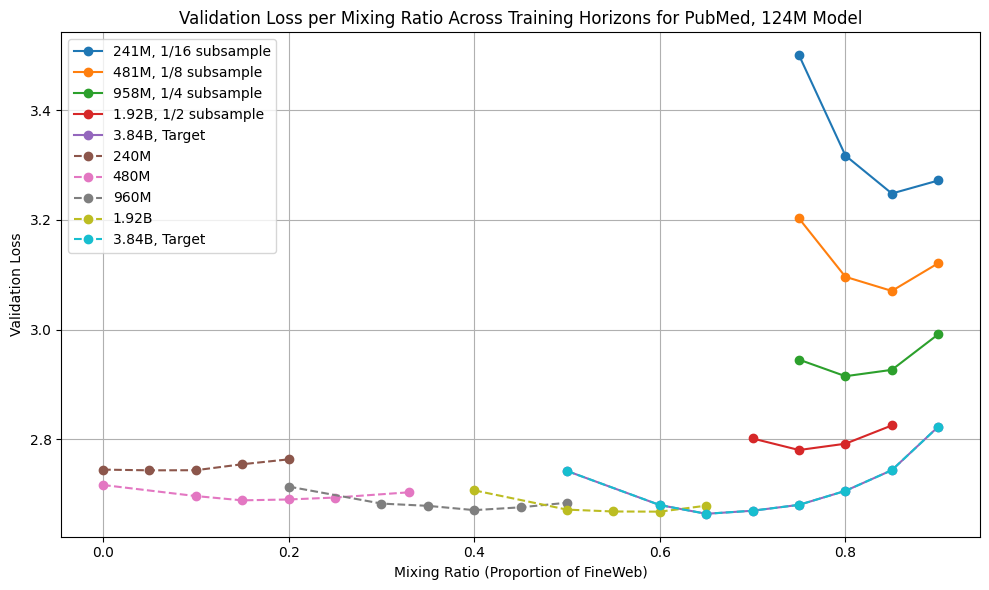

In [7]:
# PubMed
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["124M"]
legend_labels_reg = ["240M", "480M", "960M", "1.92B", "3.84B, Target"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_124M, pubmed_file_paths_reg_124M, dfs_repeat_pubmed_124M, dfs_reg_pubmed_124M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

In [8]:
# Actual Loss / Optimal Loss From Subsample Mixture Ratios 
for df in dfs_reg_pubmed_124M:
    print(f"Dataframe for {df['experiment'].iloc[0]}x PubMed")
    display(df.drop(columns=["experiment"]))

data = {
    'Subsample Used': ["1/16", "1/8", "1/4", "1/2"],
    'Loss / Optimal Loss on Target Horizon': [2.7440/2.6670, 2.7440	/2.6670, 2.7063/2.6670, 2.6808/2.6670]
}
df = pd.DataFrame(data) 
print(df)

Dataframe for 2x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.002,2.7450,15.5640
1,0.05,0.002,2.7437,15.5442
2,0.10,0.002,2.7439,15.5470
3,0.15,0.002,2.7548,15.7179
4,0.20,0.002,2.7637,15.8585


Dataframe for 4x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00282,2.7170,15.1348
1,0.10,0.00200,2.6968,14.8327
2,0.15,0.00200,2.6890,14.7170
3,0.20,0.00200,2.6906,14.7407
4,0.25,0.00141,2.6941,14.7929
5,0.33,0.00200,2.7037,14.9342


Dataframe for 8x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.20,0.00200,2.7141,15.0904
1,0.30,0.00141,2.6831,14.6303
2,0.35,0.00141,2.6790,14.5712
3,0.40,0.00141,2.6712,14.4572
4,0.45,0.00141,2.6763,14.5308
5,0.50,0.00141,2.6847,14.6539


Dataframe for 16x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.40,0.00141,2.7072,14.9880
1,0.50,0.00141,2.6721,14.4709
2,0.55,0.00100,2.6687,14.4214
3,0.60,0.00100,2.6684,14.4162
4,0.65,0.00100,2.6793,14.5748


Dataframe for 32x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,2.7425,15.5258
1,0.60,0.001,2.6804,14.5914
2,0.65,0.001,2.6645,14.3602
3,0.70,0.001,2.6701,14.4409
4,0.75,0.001,2.6808,14.5973
5,0.80,0.001,2.7063,14.9736
6,0.85,0.001,2.7440,15.5493
7,0.90,0.001,2.8232,16.8306


  Subsample Used  Loss / Optimal Loss on Target Horizon
0           1/16                               1.028871
1            1/8                               1.028871
2            1/4                               1.014736
3            1/2                               1.005174


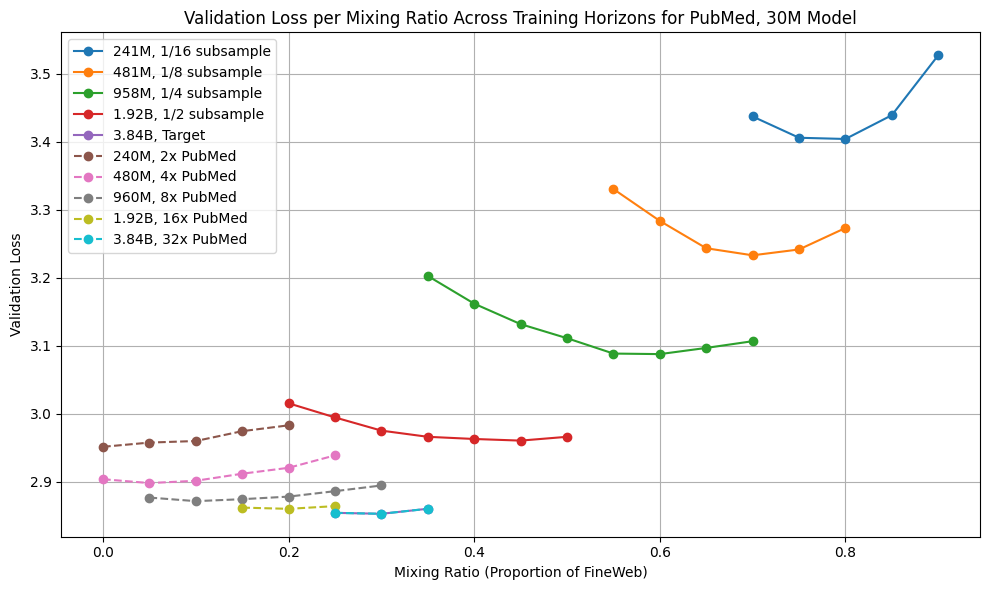

In [9]:
# 30M Parameter Model, PubMed
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["30M"]
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_30M, pubmed_file_paths_reg_30M, dfs_repeat_pubmed_30M, dfs_reg_pubmed_30M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

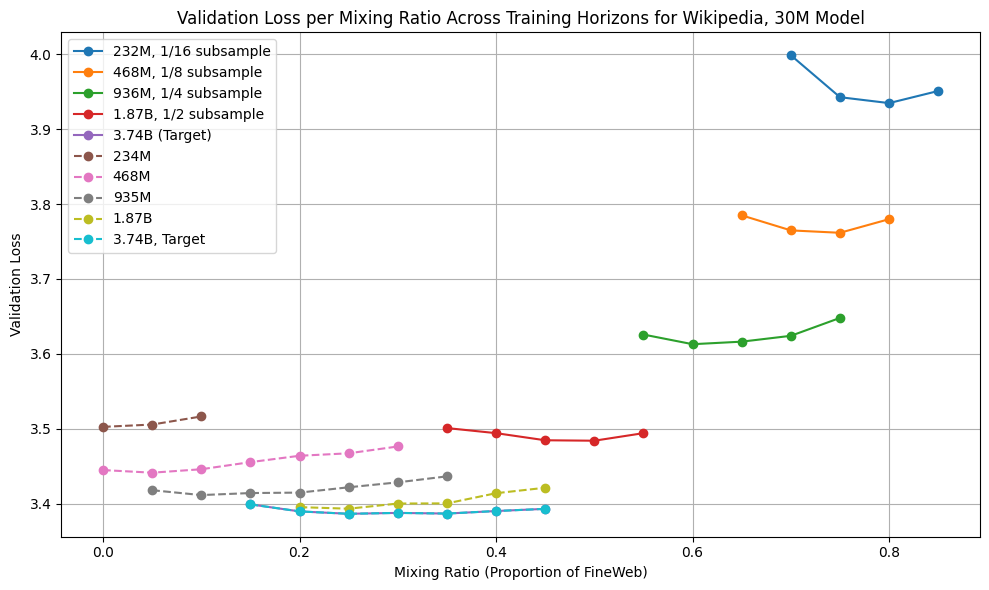

In [10]:
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["30M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
legend_labels_reg = ["234M", "468M", "935M", "1.87B", "3.74B, Target"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_30M, wiki_file_paths_reg_30M, dfs_repeat_wiki_30M, dfs_reg_wiki_30M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

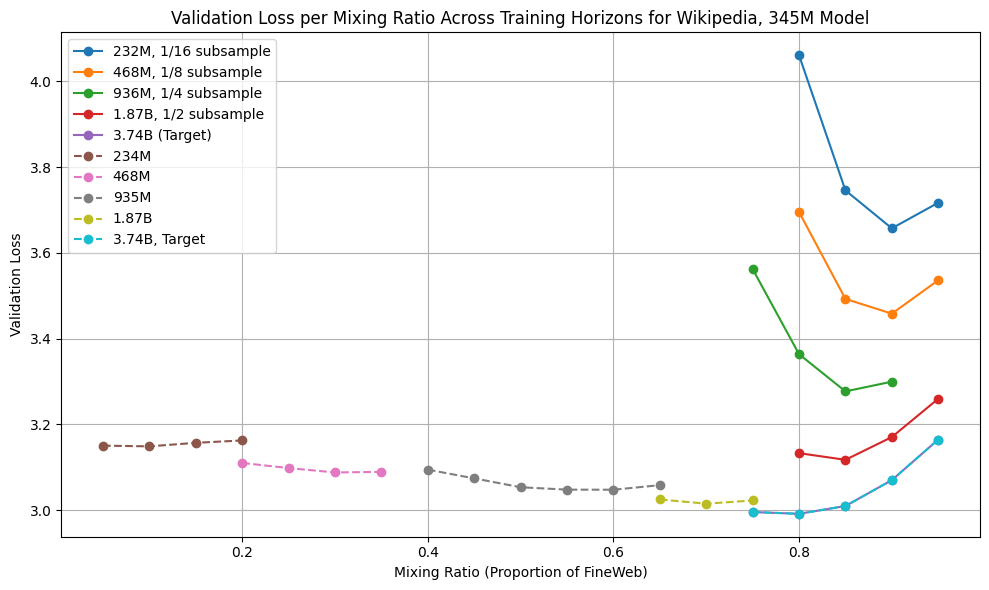

In [11]:
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["345M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
legend_labels_reg = ["234M", "468M", "935M", "1.87B", "3.74B, Target"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_345M, wiki_file_paths_reg_345M, dfs_repeat_wiki_345M, dfs_reg_wiki_345M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

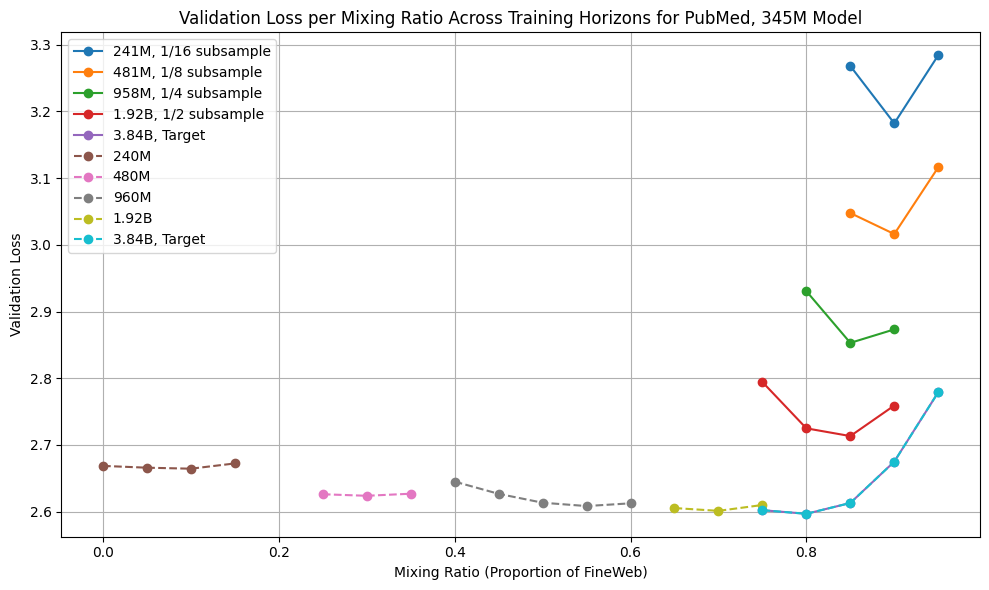

In [12]:
# 345M Model, PubMed
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["345M"]
legend_labels_reg = ["240M", "480M", "960M", "1.92B", "3.84B, Target"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_345M, pubmed_file_paths_reg_345M, dfs_repeat_pubmed_345M, dfs_reg_pubmed_345M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

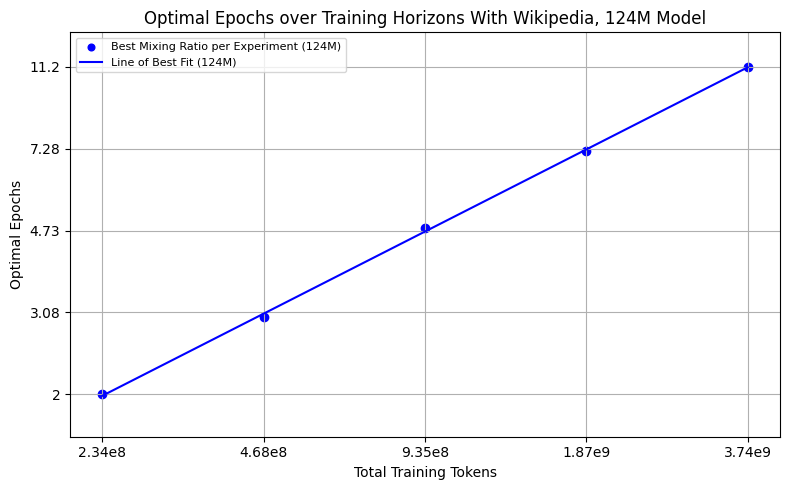

In [13]:
# Graph the Epochs for Wikipedia 124M
paths = [wiki_file_paths_reg_124M]
coefs_wiki_all, intercepts_wiki_all, epochs_all = mix_and_epochs(paths, epochs, 116881107, params=["124M"], title="Optimal Epochs over Training Horizons With Wikipedia, 124M Model")

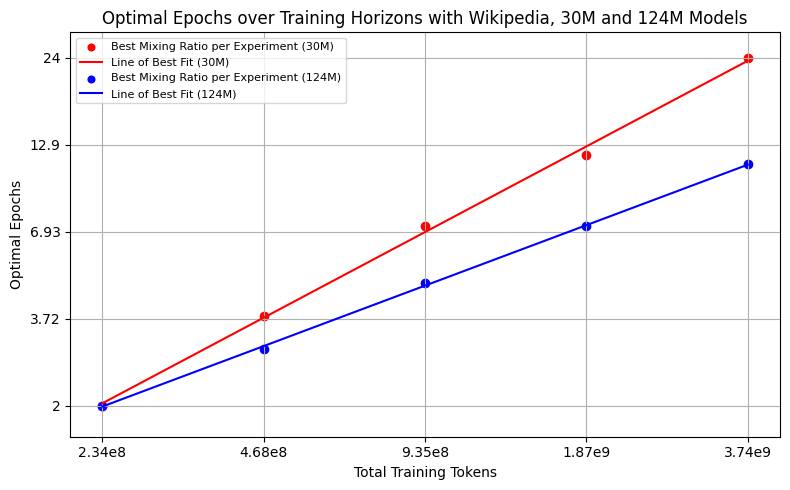

In [14]:
# Graph the Epochs for Wikipedia 30M
paths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M]
coefs_wiki_all, intercepts_wiki_all, epochs_all = mix_and_epochs(paths, epochs, 116881107, params=["30M", "124M"], colors=["red", "blue"], title="Optimal Epochs over Training Horizons with Wikipedia, 30M and 124M Models")

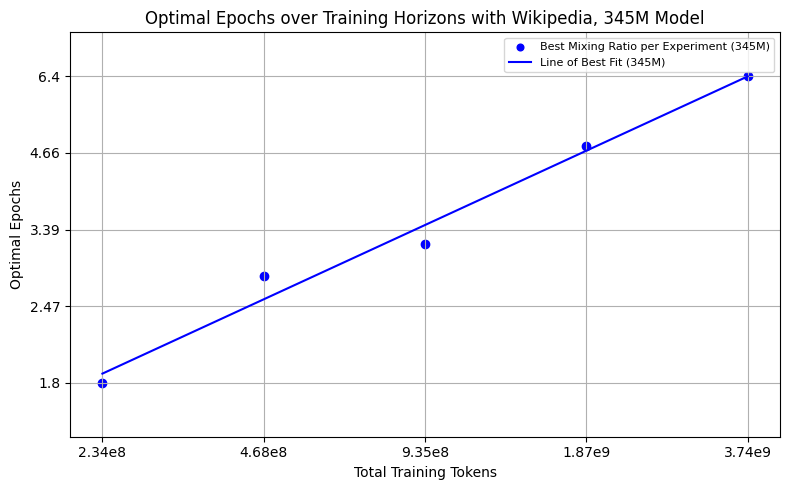

In [15]:
# Graph the Epochs for Wikipedia 345M
paths = [wiki_file_paths_reg_345M]
coefs_wiki_all, intercepts_wiki_all, epochs_all = mix_and_epochs(paths, epochs, 116881107, params=["345M"], title="Optimal Epochs over Training Horizons with Wikipedia, 345M Model")

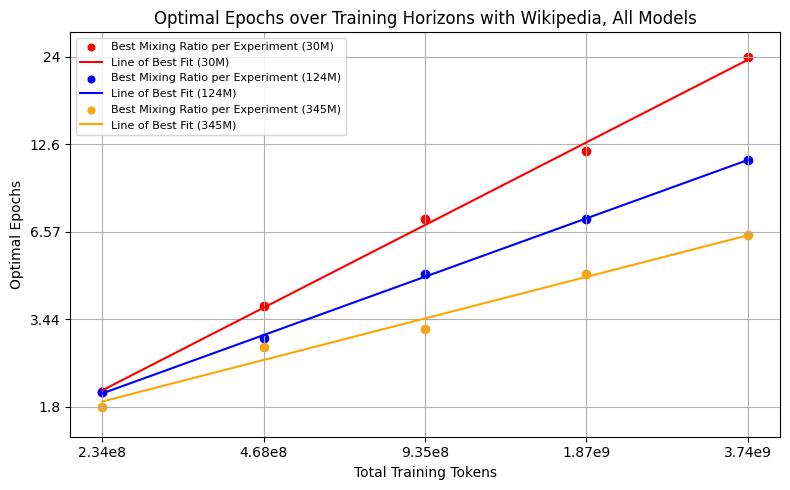

In [16]:
# Graph the Epochs for Wikipedia
paths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M, wiki_file_paths_reg_345M]
coefs_wiki_all, intercepts_wiki_all, epochs_all = mix_and_epochs(paths, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with Wikipedia, All Models")

In [17]:
print(coefs_wiki_all) # Wikipedia
print(epochs_all)

[np.float64(0.8828888083607248), np.float64(0.6233888060174277), np.float64(0.4437757575778928)]
[ 2.   3.8  7.2 12.  24.   2.   3.   4.8  7.2 11.2  1.8  2.8  3.2  4.8
  6.4]


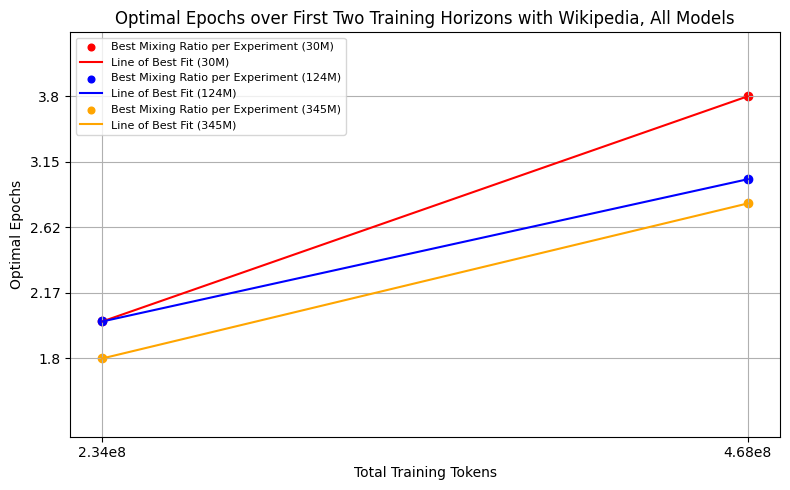

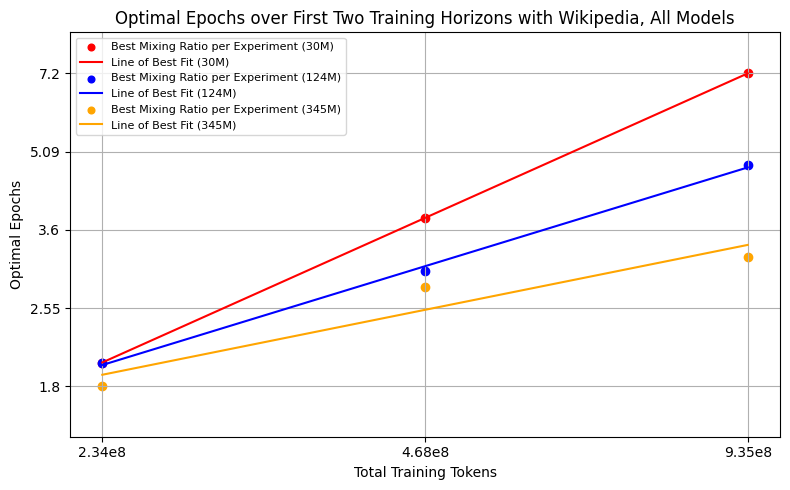

In [18]:
# Wikipedia, 2 points 
paths_two_points = [wiki_file_paths_reg_30M[0:2], wiki_file_paths_reg_124M[0:2], wiki_file_paths_reg_345M[0:2]]
coefs_wiki_all_two, intercepts_wiki_all_two, epochs_all_two = mix_and_epochs(paths_two_points, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with Wikipedia, All Models")
# Wikipedia, 3 points
paths_three_points = [wiki_file_paths_reg_30M[0:3], wiki_file_paths_reg_124M[0:3], wiki_file_paths_reg_345M[0:3]]
coefs_wiki_all_three, intercepts_wiki_all_three, epochs_all_three = mix_and_epochs(paths_three_points, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with Wikipedia, All Models")

In [19]:
def predict_epochs(coef, intercept, x_tokens: float) -> float:
    if x_tokens <= 0:
        raise ValueError("x_tokens must be > 0 for log-space prediction.")
    return float(np.exp(intercept + coef * np.log(x_tokens)))

def predict_func(experiment_horizon, num_tokens, num_iterations, coefs_two, intercepts_two, coefs_three, intercepts_three, epochs):
    #experiment_horizon = 32.0
    #num_tokens = 116881107     
    #num_iterations = 114142
    
    x_target = num_iterations * 128 * 256
    
    # Predicting when using 2 horizons
    params = ["30M", "124M", "345M"]  
    preds = {
        params[i]: predict_epochs(coefs_two[i], intercepts_two[i], x_target)
        for i in range(len(coefs_two))
    }
    for k, v in preds.items():
        print(f"{k}: predicted optimal epochs at horizon {experiment_horizon:g} ≈ {v:.3f}")
    print("Two point coefs:", coefs_two,)
    print("Two point intercepts:", intercepts_two)
    
    # Predicting when using 3 horizons
    params = ["30M", "124M", "345M"] 
    preds = {
        params[i]: predict_epochs(coefs_three[i], intercepts_three[i], x_target)
        for i in range(len(coefs_three))
    }
    for k, v in preds.items():
        print(f"{k}: predicted optimal epochs at horizon {experiment_horizon:g} ≈ {v:.3f}")
    print("Three point coefs: ", coefs_three)
    print("Three point intercepts: ", intercepts_three)
    print("Optimal epochs", epochs)

In [20]:
# Wikipedia, Scaling Laws 
experiment_horizon = 32.0
num_tokens = 116881107     
num_iterations = 114142
# Predictions for the WikiText scaling laws experiments
predict_func(experiment_horizon=experiment_horizon, num_tokens = num_tokens, num_iterations = num_iterations, coefs_two = coefs_wiki_all_two,
             intercepts_two = intercepts_wiki_all_two, coefs_three = coefs_wiki_all_three, intercepts_three = intercepts_wiki_all_three, epochs = epochs_all)

30M: predicted optimal epochs at horizon 32 ≈ 26.064
124M: predicted optimal epochs at horizon 32 ≈ 10.125
345M: predicted optimal epochs at horizon 32 ≈ 10.539
Two point coefs: [np.float64(0.9259994185562206), np.float64(0.5849625007211547), np.float64(0.6374299206152897)]
Two point intercepts: [np.float64(-17.15069028398948), np.float64(-10.57897197692194), np.float64(-11.695369966269464)]
30M: predicted optimal epochs at horizon 32 ≈ 25.932
124M: predicted optimal epochs at horizon 32 ≈ 11.397
345M: predicted optimal epochs at horizon 32 ≈ 5.989
Three point coefs:  [np.float64(0.9239984532774751), np.float64(0.631517202916897), np.float64(0.415037499278844)]
Three point intercepts:  [np.float64(-17.111669732145184), np.float64(-11.486828894740942), np.float64(-7.358525594847929)]
Optimal epochs [ 2.   3.8  7.2 12.  24.   2.   3.   4.8  7.2 11.2  1.8  2.8  3.2  4.8
  6.4]


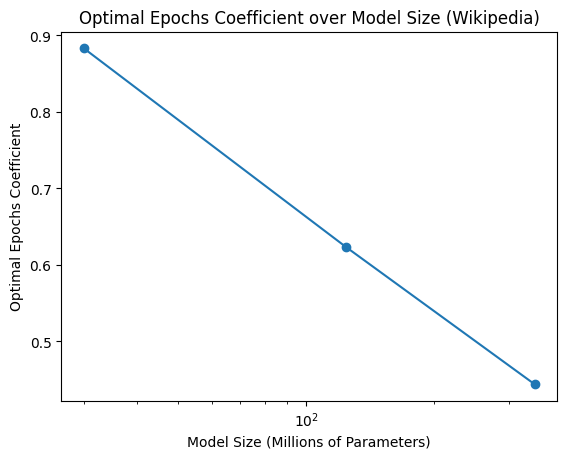

In [21]:
x = (([30, 124, 345]))
y = coefs_wiki_all

plt.plot(x, y, '-o') 

plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Optimal Epochs Coefficient")
plt.title("Optimal Epochs Coefficient over Model Size (Wikipedia)")
plt.xscale("log")
plt.show()

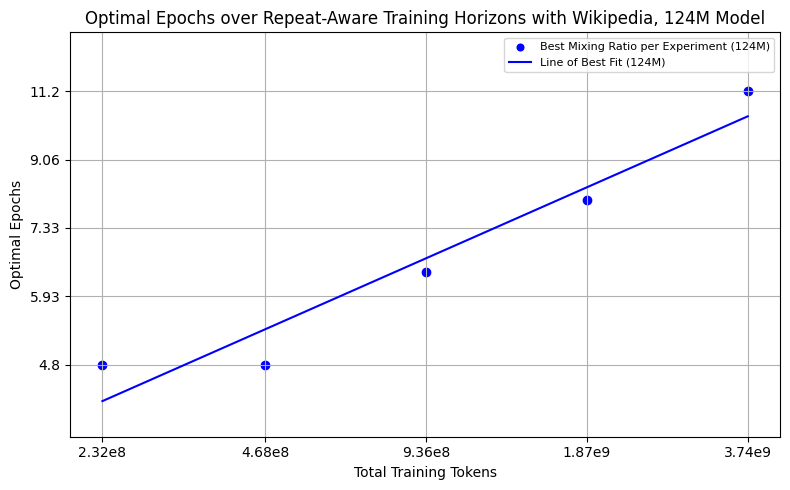

In [22]:
# Wikipedia Repeat-Aware
# legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
repeat_aware_tokens = {2.0:232e6, 4.0:468e6, 8.0:936e6, 16.0:1.87e9, 32.0:3.74e9}
paths_rep_124M = [wiki_file_paths_124M]
coefs_wiki_124M_rep, intercepts_wiki_124M_rep, epochs_124M_rep = mix_and_epochs(paths_rep_124M, epochs, 116881107, colors=["blue"], params=["124M"], title="Optimal Epochs over Repeat-Aware Training Horizons with Wikipedia, 124M Model",repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens)

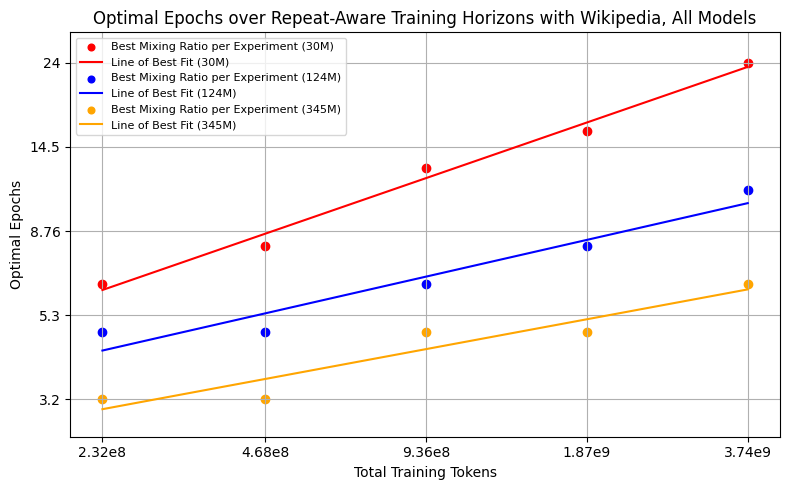

In [23]:
# Wikipedia Repeat-Aware
# legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
repeat_aware_tokens = {2.0:232e6, 4.0:468e6, 8.0:936e6, 16.0:1.87e9, 32.0:3.74e9}
paths_rep = [wiki_file_paths_30M, wiki_file_paths_124M, wiki_file_paths_345M]
coefs_wiki_all_rep, intercepts_wiki_all_rep, epochs_all_rep = mix_and_epochs(paths_rep, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Repeat-Aware Training Horizons with Wikipedia, All Models",repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens)

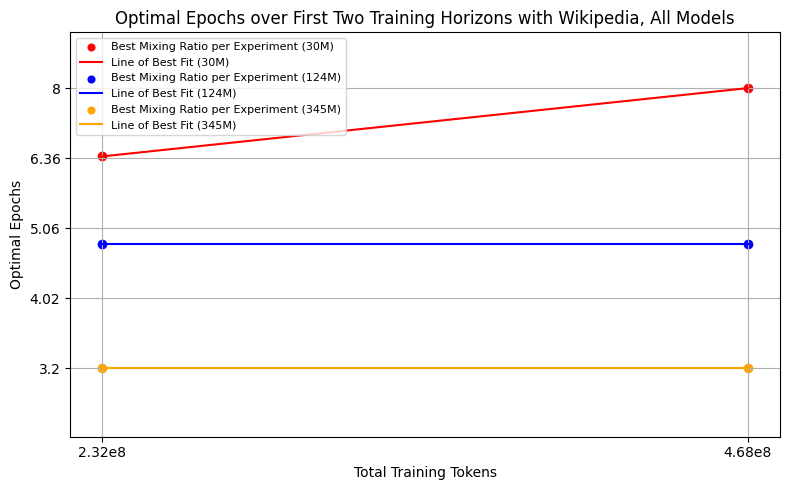

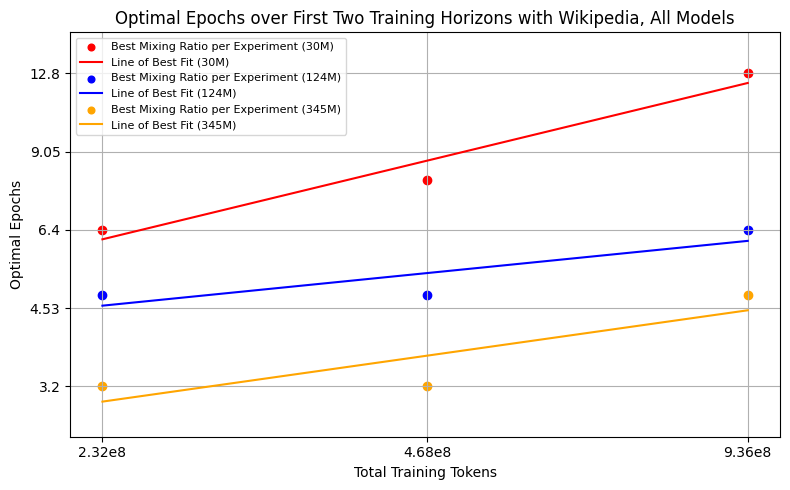

In [24]:
# Wikipedia, 2 points 
paths_two_points_rep = [wiki_file_paths_30M[0:2], wiki_file_paths_124M[0:2], wiki_file_paths_345M[0:2]]
coefs_wiki_all_two_rep, intercepts_wiki_all_two_rep, epochs_all_two_rep = mix_and_epochs(paths_two_points_rep, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with Wikipedia, All Models", repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens)
# Wikipedia, 3 points
paths_three_points_rep = [wiki_file_paths_30M[0:3], wiki_file_paths_124M[0:3], wiki_file_paths_345M[0:3]]
coefs_wiki_all_three_rep, intercepts_wiki_all_three_rep, epochs_all_three_rep = mix_and_epochs(paths_three_points_rep, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with Wikipedia, All Models", repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens)

In [25]:
# Wikipedia, Repeat-Aware
experiment_horizon = 32.0
num_tokens = 116881107     
num_iterations = 114142 
# Predictions for the WikiText scaling laws experiments
predict_func(experiment_horizon=experiment_horizon, num_tokens = num_tokens, num_iterations = num_iterations, coefs_two = coefs_wiki_all_two_rep,
             intercepts_two = intercepts_wiki_all_two_rep, coefs_three = coefs_wiki_all_three_rep, intercepts_three = intercepts_wiki_all_three_rep, epochs = epochs_all_rep)

30M: predicted optimal epochs at horizon 32 ≈ 15.493
124M: predicted optimal epochs at horizon 32 ≈ 4.800
345M: predicted optimal epochs at horizon 32 ≈ 3.200
Two point coefs: [np.float64(0.31799019197034295), np.float64(0.0), np.float64(0.0)]
Two point intercepts: [np.float64(-4.268907926557944), np.float64(1.5686159179138455), np.float64(1.1631508098056806)]
30M: predicted optimal epochs at horizon 32 ≈ 24.415
124M: predicted optimal epochs at horizon 32 ≈ 8.108
345M: predicted optimal epochs at horizon 32 ≈ 6.700
Three point coefs:  [np.float64(0.4965538297996419), np.float64(0.2058160773010945), np.float64(0.2900814684838391)]
Three point intercepts:  [np.float64(-7.750041160009129), np.float64(-2.443808982145165), np.float64(-4.492044461880947)]
Optimal epochs [ 6.4  8.  12.8 16.  24.   4.8  4.8  6.4  8.  11.2  3.2  3.2  4.8  4.8
  6.4]


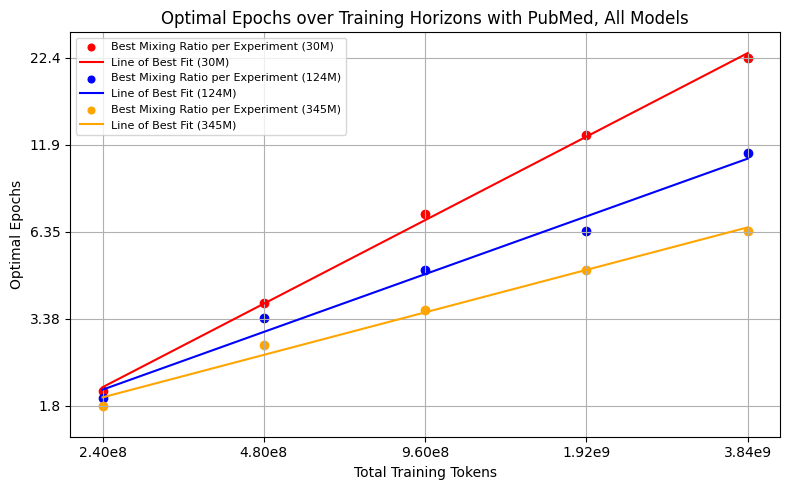

In [26]:
paths = [pubmed_file_paths_reg_30M, pubmed_file_paths_reg_124M, pubmed_file_paths_reg_345M]
coefs_pubmed_all, intercepts_pubmed_all, epochs_pubmed_all = mix_and_epochs(paths, epochs, 120000060, colors=["red", "blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with PubMed, All Models", smaller_legend=True)

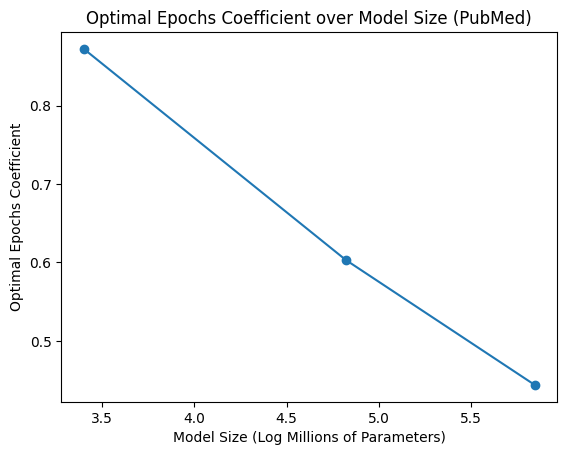

In [27]:
x = np.log(([30, 124, 345]))
y = coefs_pubmed_all

plt.plot(x, y, '-o') 

plt.xlabel("Model Size (Log Millions of Parameters)")
plt.ylabel("Optimal Epochs Coefficient")
plt.title("Optimal Epochs Coefficient over Model Size (PubMed)")
plt.show()

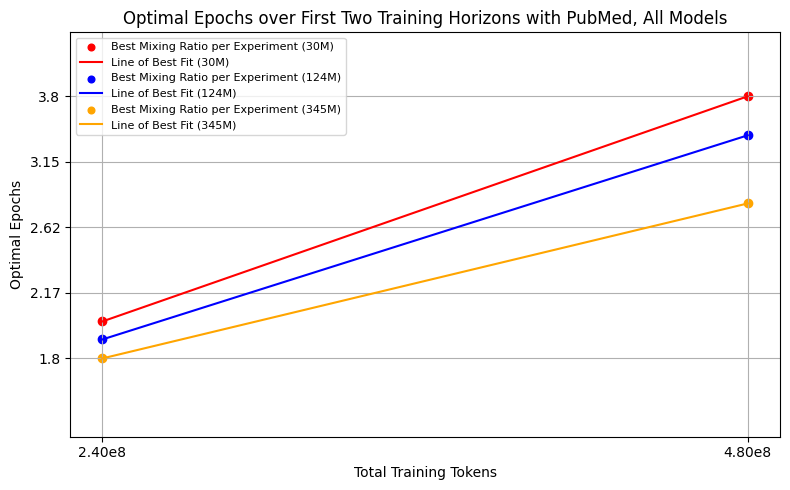

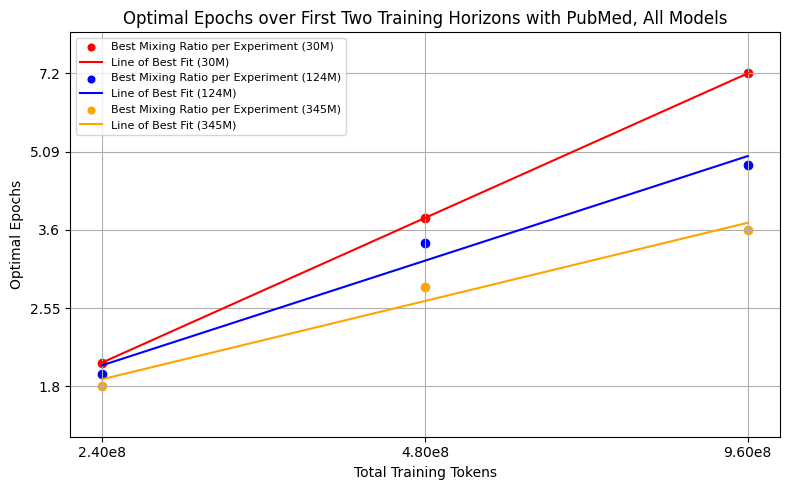

In [28]:
# Two and Three Horizon Predictions for PubMed
# paths = [pubmed_file_paths_reg_30M, pubmed_file_paths_reg_124M, pubmed_file_paths_reg_345M]
#coefs_pubmed_all, intercepts_pubmed_all, epochs_pubmed_all = mix_and_epochs(paths, epochs, 120000060, colors=["red", "blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with PubMed, All Models")
# PubMed, 2 points 
paths_two_points = [pubmed_file_paths_reg_30M[0:2],pubmed_file_paths_reg_124M[0:2], pubmed_file_paths_reg_345M[0:2]]
coefs_pubmed_all_two, intercepts_pubmed_all_two, epochs_all_two = mix_and_epochs(paths_two_points, epochs, 120000060, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with PubMed, All Models")
# PuibMed, 3 points
paths_three_points = [pubmed_file_paths_reg_30M[0:3], pubmed_file_paths_reg_124M[0:3], pubmed_file_paths_reg_345M[0:3]]
coefs_pubmed_all_three, intercepts_pubmed_all_three, epochs_all_three = mix_and_epochs(paths_three_points, epochs, 120000060, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Training Horizons with PubMed, All Models" )

In [29]:
# Predictions for two and three horizons, PubMed
# Scaling Laws 
experiment_horizon = 32.0
num_tokens = 120000060    
num_iterations = 117188
# Predictions for the scaling laws experiments
predict_func(experiment_horizon=experiment_horizon, num_tokens = num_tokens, num_iterations = num_iterations, coefs_two = coefs_pubmed_all_two,
             intercepts_two = intercepts_pubmed_all_two, coefs_three = coefs_pubmed_all_three, intercepts_three = intercepts_pubmed_all_three, epochs = epochs_pubmed_all)

30M: predicted optimal epochs at horizon 32 ≈ 26.064
124M: predicted optimal epochs at horizon 32 ≈ 19.483
345M: predicted optimal epochs at horizon 32 ≈ 10.539
Two point coefs: [np.float64(0.9259994185562206), np.float64(0.8395353278067517), np.float64(0.6374299206152897)]
Two point intercepts: [np.float64(-17.175076482503165), np.float64(-15.557945713791701), np.float64(-11.712156685862578)]
30M: predicted optimal epochs at horizon 32 ≈ 25.932
124M: predicted optimal epochs at horizon 32 ≈ 12.615
345M: predicted optimal epochs at horizon 32 ≈ 7.432
Three point coefs:  [np.float64(0.9239984532774751), np.float64(0.6685174936387857), np.float64(0.5000000000000001)]
Three point intercepts:  [np.float64(-17.13600323522999), np.float64(-12.218446426348823), np.float64(-9.028535271751265)]
Optimal epochs [ 2.   3.8  7.2 12.8 22.4  1.9  3.4  4.8  6.4 11.2  1.8  2.8  3.6  4.8
  6.4]


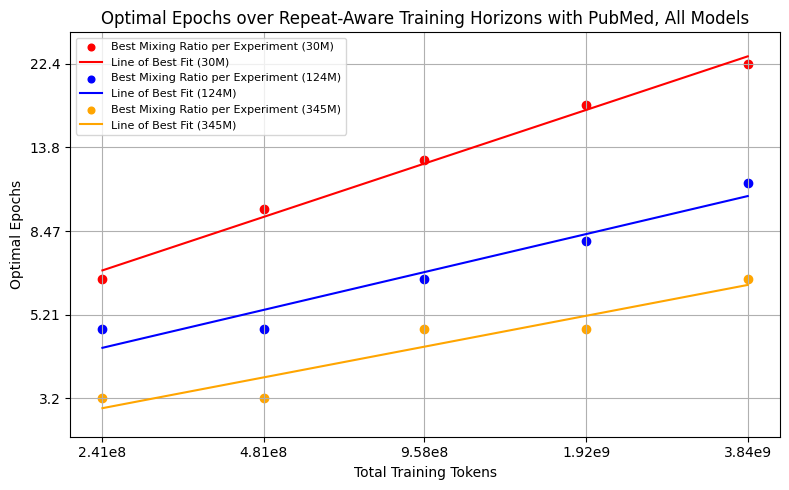

In [30]:
# PubMed, Repeat-Aware Full
repeat_aware_tokens_pubmed = {2.0:241e6, 4.0:481e6, 8.0:958e6, 16.0:1.92e9, 32.0:3.84e9}
paths_rep = [pubmed_file_paths_30M,pubmed_file_paths_124M, pubmed_file_paths_345M]
coefs_pubmed_all_rep, intercepts_pubmed_rep, epochs_rep = mix_and_epochs(paths_rep, epochs, 120000060, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Repeat-Aware Training Horizons with PubMed, All Models", repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens_pubmed, smaller_legend=True)
# PuibMed, 3 points

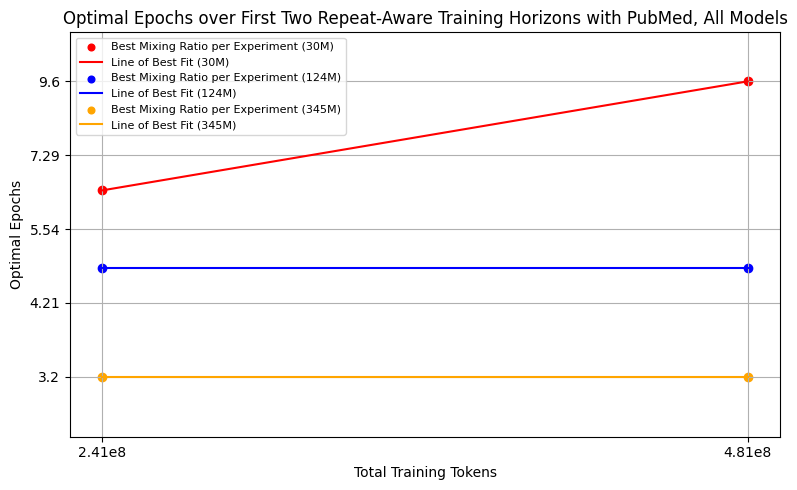

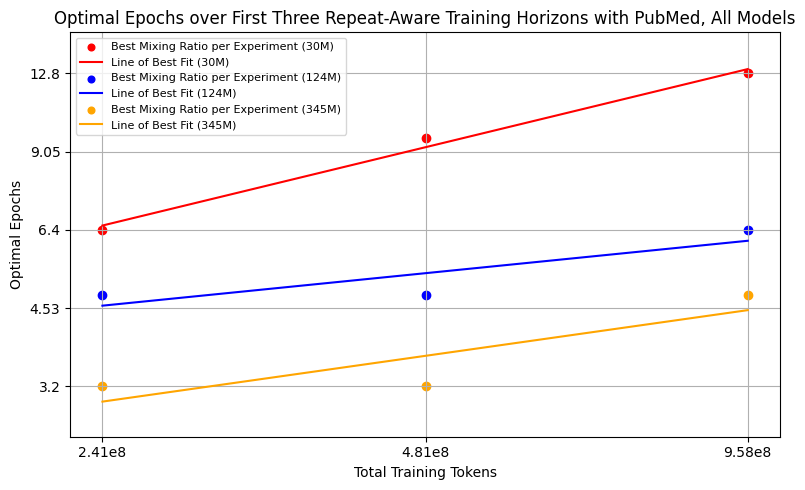

In [31]:
# PubMed, Repeat-Aware
# Two and Three Horizon Predictions for PubMed
# paths = [pubmed_file_paths_reg_30M, pubmed_file_paths_reg_124M, pubmed_file_paths_reg_345M]
#coefs_pubmed_all, intercepts_pubmed_all, epochs_pubmed_all = mix_and_epochs(paths, epochs, 120000060, colors=["red", "blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with PubMed, All Models")
# PubMed, 2 points 
repeat_aware_tokens_pubmed = {2.0:241e6, 4.0:481e6, 8.0:958e6, 16.0:1.92e9, 32.0:3.84e9}
paths_two_points_rep = [pubmed_file_paths_30M[0:2],pubmed_file_paths_124M[0:2], pubmed_file_paths_345M[0:2]]
coefs_pubmed_all_two_rep, intercepts_pubmed_all_two_rep, epochs_all_two_rep = mix_and_epochs(paths_two_points_rep, epochs, 120000060, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Two Repeat-Aware Training Horizons with PubMed, All Models", repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens_pubmed)
# PuibMed, 3 points
paths_three_points_rep = [pubmed_file_paths_30M[0:3], pubmed_file_paths_124M[0:3], pubmed_file_paths_345M[0:3]]
coefs_pubmed_all_three_rep, intercepts_pubmed_all_three_rep, epochs_all_three_rep = mix_and_epochs(paths_three_points_rep, epochs, 120000060, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over First Three Repeat-Aware Training Horizons with PubMed, All Models", repeat_aware=True, repeat_aware_tokens=repeat_aware_tokens_pubmed)

In [32]:
# Predictions for two and three horizons, PubMed Repeat-Aware
# PubMed, Repeat-Aware
experiment_horizon = 32.0
num_tokens = 120000060    
num_iterations = 117188
# Predictions for the PubMed Repeat-Aware experiments
predict_func(experiment_horizon=experiment_horizon, num_tokens = num_tokens, num_iterations = num_iterations, coefs_two = coefs_pubmed_all_two_rep,
             intercepts_two = intercepts_pubmed_all_two_rep, coefs_three = coefs_pubmed_all_three_rep, intercepts_three = intercepts_pubmed_all_three_rep, epochs = epochs_pubmed_all)

30M: predicted optimal epochs at horizon 32 ≈ 32.479
124M: predicted optimal epochs at horizon 32 ≈ 4.800
345M: predicted optimal epochs at horizon 32 ≈ 3.200
Two point coefs: [np.float64(0.5867204633527631), np.float64(0.0), np.float64(0.0)]
Two point intercepts: [np.float64(-9.467587363871615), np.float64(1.5686159179138455), np.float64(1.1631508098056806)]
30M: predicted optimal epochs at horizon 32 ≈ 26.215
124M: predicted optimal epochs at horizon 32 ≈ 8.146
345M: predicted optimal epochs at horizon 32 ≈ 6.743
Three point coefs:  [np.float64(0.5023047570416176), np.float64(0.2083522069202578), np.float64(0.2936559424211496)]
Three point intercepts:  [np.float64(-7.818912185960059), np.float64(-2.500592607646613), np.float64(-4.572076487013752)]
Optimal epochs [ 2.   3.8  7.2 12.8 22.4  1.9  3.4  4.8  6.4 11.2  1.8  2.8  3.6  4.8
  6.4]


In [33]:
# Plotting the optimal learning rates for each set of experiments
def get_optimal_learning_rates_nested(df_groups, model_sizes, training_horizons):
    """
    Args:
        df_groups: list of lists of DataFrames (some entries may be None or missing)
        model_sizes: list of strings (same length as df_groups)
        training_horizons: list of floats (same length as each sublist in df_groups)

    Returns:
        Dict mapping model_size -> list of (training_horizon, optimal_learning_rate)
    """
    from collections import defaultdict

    results = defaultdict(list)

    assert len(df_groups) == len(model_sizes), "Mismatch between model_sizes and df_groups"

    for model_size, df_list in zip(model_sizes, df_groups):
        for df, horizon in zip(df_list, training_horizons):
            if df is None or df.empty:
                continue  # skip if no data for this horizon

            if 'val_loss' not in df.columns or df['val_loss'].isnull().all():
                continue  # skip if no valid val_loss

            best_row = df.loc[df['val_loss'].idxmin()]
            results[model_size].append((horizon, best_row['learning_rate']))

        # Sort by horizon just in case
        results[model_size].sort(key=lambda x: x[0])

    return results


def plot_optimal_learning_rates(results, experiment_type = "Regular"):
    """
    Given a dict {model_size: list of (horizon, lr)}, plot the results.
    """
    plt.figure(figsize=(8,6))

    for model_size, horizon_lrs in results.items():
        horizons, lrs = zip(*horizon_lrs)
        plt.plot(horizons, lrs, marker='o', label=f'{model_size} model')

    plt.xlabel("Training Horizon (tokens)")
    plt.ylabel("Optimal Learning Rate")
    plt.title(f"Optimal Learning Rate vs Training Horizon ({experiment_type})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


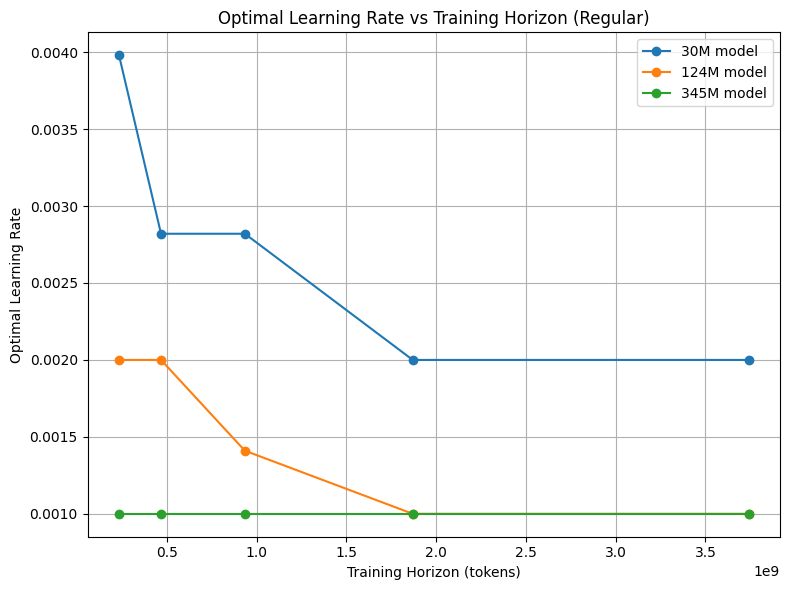

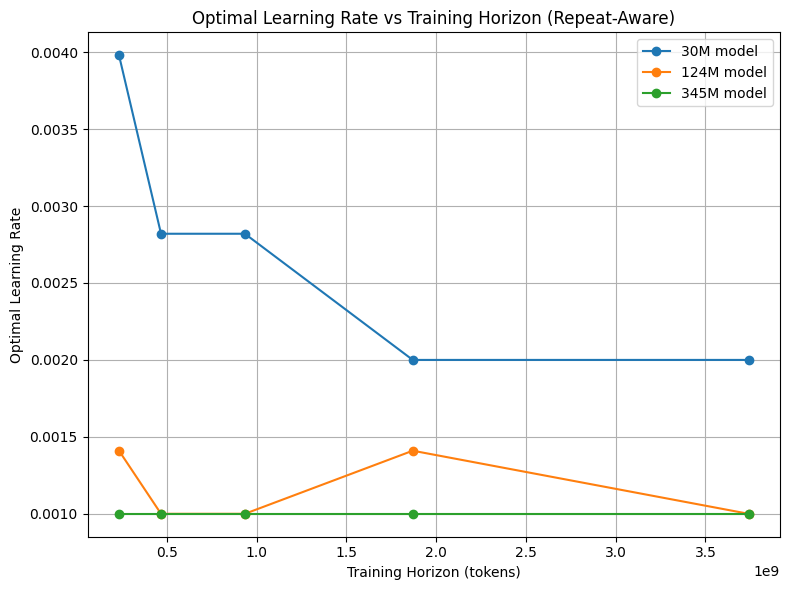

In [34]:
# dfs_repeat_wiki_30M, dfs_reg_wiki_30M
list_dfs_wiki = [dfs_reg_wiki_30M, dfs_reg_wiki_124M, dfs_reg_wiki_345M]
list_dfs_wiki_repeat = [dfs_repeat_wiki_30M, dfs_repeat_wiki_124M, dfs_repeat_wiki_345M]
model_sizes_wiki = ["30M", "124M", "345M"]
# ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
training_horizons_wiki = [234e6, 468e6, 935e6, 187e7, 374e7]
# ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
training_horizons_wiki_repeat = [232e6, 468e6, 936e6, 187e7, 374e7]
results_wiki_reg = get_optimal_learning_rates_nested(list_dfs_wiki, model_sizes_wiki, training_horizons_wiki)
plot_optimal_learning_rates(results_wiki_reg)
results_wiki_repeat = get_optimal_learning_rates_nested(list_dfs_wiki_repeat, model_sizes_wiki, training_horizons_wiki) 
# note that the .00141 "outlier" was only better by .0001
plot_optimal_learning_rates(results_wiki_repeat, "Repeat-Aware")

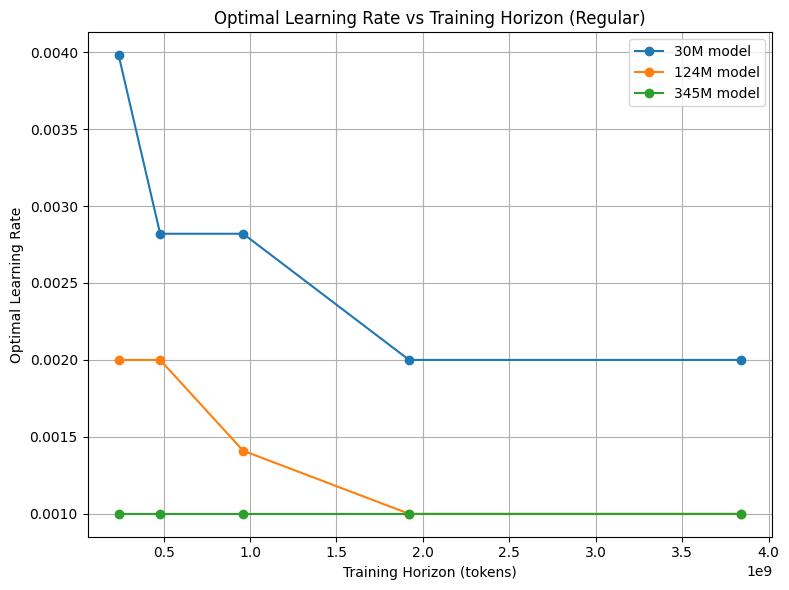

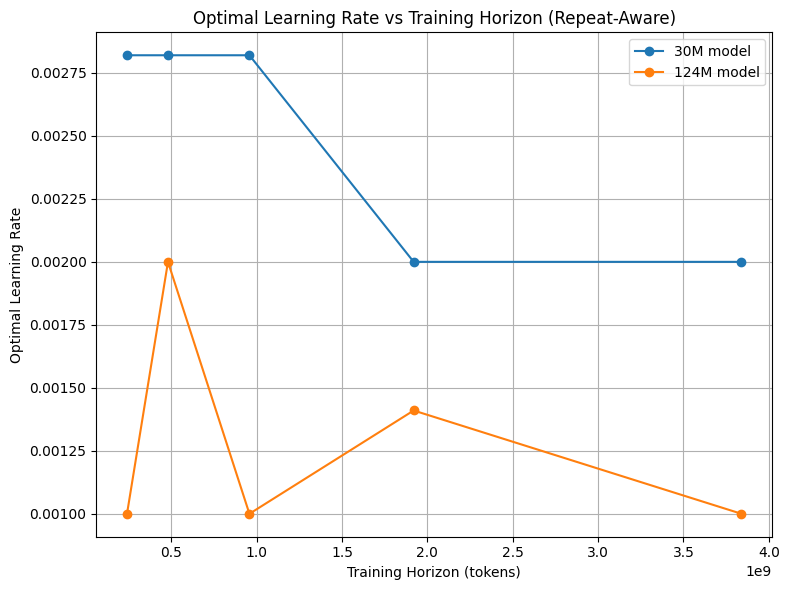

In [35]:
list_dfs_pub = [dfs_reg_pubmed_30M, dfs_reg_pubmed_124M, dfs_reg_pubmed_345M]
model_sizes_pub = ["30M", "124M", "345M"]
# ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"
training_horizons_pub = [240e6, 480e6, 960e6, 192e7, 384e7]
results_pub = get_optimal_learning_rates_nested(list_dfs_pub, model_sizes_pub, training_horizons_pub)
# legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
training_horizons_pub_repeat = [241e6, 481e6, 958e6, 192e7, 384e7]
list_dfs_pub_repeat = [dfs_repeat_pubmed_30M, dfs_repeat_pubmed_124M]
plot_optimal_learning_rates(results_pub)
model_sizes_pub_repeat = ["30M", "124M"]
results_pub_repeat = get_optimal_learning_rates_nested(list_dfs_pub_repeat, model_sizes_pub_repeat, training_horizons_pub_repeat)
plot_optimal_learning_rates(results_pub_repeat, "Repeat-Aware")

In [36]:
import re
import pandas as pd
import matplotlib.pyplot as plt

LOG_RE = re.compile(
    r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)"
)

def all_runs_df(file_paths, epochs):
    rows = []
    for path, exp in zip(file_paths, epochs):
        with open(path, "r") as f:
            for line in f:
                m = LOG_RE.search(line)
                if not m:
                    continue
                rows.append({
                    "experiment": str(exp),
                    "mixing_ratio": float(m.group(1)),
                    "learning_rate": float(m.group(2)),
                    "val_loss": float(m.group(3)),
                    "perplexity": float(m.group(4)),
                })
    return pd.DataFrame(rows)

def plot_loss_vs_lr(df, experiment=None):
    d = df.copy()
    if experiment is not None:
        d = d[d["experiment"] == str(experiment)]

    # sort by lr within each mix so lines don’t zig-zag
    for mix, g in d.groupby("mixing_ratio"):
        g = g.sort_values("learning_rate")
        plt.plot(g["learning_rate"], g["val_loss"], marker="o", label=f"mix={mix:g}")

    plt.xscale("log")  # usually helpful for LR sweeps
    plt.xlabel("learning rate")
    plt.ylabel("validation loss")
    plt.title(f"Val loss vs LR{' — '+str(experiment) if experiment else ''}")
    plt.legend()
    plt.tight_layout()
    plt.show()

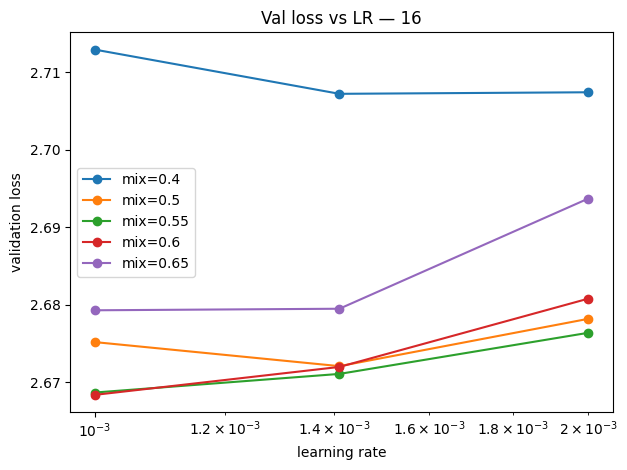

In [37]:
pubmed_124M = all_runs_df(pubmed_file_paths_reg_124M, [2,4,8,16,32])
plot_loss_vs_lr(pubmed_124M, experiment=16)

In [38]:
import re
import numpy as np
import pandas as pd
from IPython.display import display, HTML

LOG_PATTERN = re.compile(
    r"mixing_ratio=\[(.*?)\]\s*,\s*learning_rate=([^\s,]+)\s*,\s*val_loss=([^\s,]+)\s*,\s*perplexity=[^\s,]+\s*,\s*val_loss_2=([^\s,]+)\s*,\s*perplexity_2=[^\s,]+",
    re.IGNORECASE,
)

def parse_results_file(filepath: str):
    """Parse one log file into rows: [mix_str, lr, avg_val, mix_tuple]."""
    records = []
    with open(filepath, "r") as f:
        for raw in f:
            m = LOG_PATTERN.search(raw)
            if not m:
                continue
            mix_list = [float(x.strip()) for x in m.group(1).split(",")]
            mixing_ratio_str = f"[{', '.join(f'{v:g}' for v in mix_list)}]"
            lr = float(m.group(2))
            val1 = float(m.group(3))
            val2 = float(m.group(4))
            avg_val = (val1 + val2) / 2.0
            records.append([mixing_ratio_str, lr, avg_val, tuple(mix_list)])
    cols = ["Mixing Ratio", "Learning Rate", "Avg Val Loss", "_mix_tuple"]
    return pd.DataFrame(records, columns=cols) if records else pd.DataFrame(columns=cols)

def _is_close_tuple(a, b, atol=1e-8, rtol=1e-6):
    if a is None or b is None:
        return False
    if len(a) != len(b):
        return False
    return all(np.isclose(ax, bx, atol=atol, rtol=rtol) for ax, bx in zip(a, b))

def add_baseline_tags(
    df: pd.DataFrame,
    baseline1=None, baseline2=None,
    baseline1_label="Baseline 1", baseline2_label="Baseline 2",
    atol=1e-8, rtol=1e-6
):

    b1 = tuple(baseline1) if baseline1 is not None else None
    b2 = tuple(baseline2) if baseline2 is not None else None

    def tag_row(tup):
        if _is_close_tuple(tup, b1, atol=atol, rtol=rtol):
            return baseline1_label
        if _is_close_tuple(tup, b2, atol=atol, rtol=rtol):
            return baseline2_label
        return "Tuned"

    out = df.copy()
    out["Set"] = [tag_row(t) for t in out.get("_mix_tuple", [])]
    return out


def style_table(df: pd.DataFrame):

    if df.empty:
        return df.style

    sty = df.style.format({
        "Learning Rate": "{:.6g}".format,
        "Avg Val Loss": "{:.5f}".format,
    })

    min_idx = df["Avg Val Loss"].idxmin()
    sty = sty.apply(
        lambda row: ["font-weight: bold" if row.name == min_idx else "" for _ in row],
        axis=1
    )

    def row_colors(row):
        if "Set" not in df.columns:
            return ["" for _ in row]
        if row["Set"] == "Baseline 1":
            return ["background-color: #fff3cd" for _ in row]  # light amber
        if row["Set"] == "Baseline 2":
            return ["background-color: #d1e7dd" for _ in row]  # light green
        return ["" for _ in row]

    return sty.apply(row_colors, axis=1)


# main function to display the results in tables
def display_results_tables(
    filepaths,
    baseline1=None, baseline2=None,
    baselines_by_file: dict | None = None,
    group_by_first_mix: bool = True,
    sort_by_avg_within_groups: bool = True,
    show_counts: bool = True,
    subsamples = None,
):
    """ Displays the best performing learning rate per mixing ratio. """
    
    for index, fp in enumerate(filepaths):
        df_full = parse_results_file(fp)

        b1 = baseline1
        b2 = baseline2
        if baselines_by_file is not None and subsamples is not None:
            b1 = baselines_by_file[subsamples[index]].get("baseline1", b1)
            b2 = baselines_by_file[subsamples[index]].get("baseline2", b2)

        df_full = add_baseline_tags(df_full, baseline1=b1, baseline2=b2)

        # getting the best lr 
        if not df_full.empty:
            idx = df_full.groupby("_mix_tuple")["Avg Val Loss"].idxmin()
            df = df_full.loc[idx, ["Mixing Ratio", "Learning Rate", "Avg Val Loss", "Set", "_mix_tuple"]]
            df = df.reset_index(drop=True)
        else:
            df = df_full

        if not df.empty and group_by_first_mix:
            df["_mix0"] = [t[0] if isinstance(t, tuple) and len(t) > 0 else np.nan for t in df["_mix_tuple"]]
            sort_cols = ["_mix0"]
            if sort_by_avg_within_groups:
                sort_cols.append("Avg Val Loss")
            df = df.sort_values(sort_cols, ascending=True, ignore_index=True)

        display(HTML(f"<h3 style='margin-top:1.2em'>Results (best lr per mixture): 1/{subsamples[index]} subsample</h3>"))
        if show_counts:
            unique_mixes = 0 if df.empty else df["_mix_tuple"].nunique()
            display(HTML(f"<div>Unique mixes: <b>{unique_mixes}</b></div>"))
        display(style_table(df.drop(columns=["_mix_tuple", "_mix0"], errors="ignore")))
       
# display
iters_list = [7238, 14480, 28908, 57842, 115665]
subsamples = [16, 8, 4, 2, 1]
files_list = []
baselines = {} 
baseline_ones = [[0.7, 0.15, 0.15], [0.7, 0.15, 0.15], [0.6, 0.2, 0.2], [0.5, 0.25, 0.25], [0.3, 0.35, 0.35]]
baseline_twos = [[0.85, 0.075, 0.075], [0.85, 0.075, 0.075], [0.8, 0.1, 0.1], [0.75, 0.125, 0.125], [0.65, 0.175, 0.175]] 
for i in range(len(iters_list)):
    files_list.append(f"./summary_logs/wiki_pubmed/summary_{iters_list[i]}iter_124M_{subsamples[i]}.txt")
    baselines[subsamples[i]] = {"baseline1" : baseline_ones[i], "baseline2" : baseline_twos[i]}

display_results_tables(files_list, baselines_by_file=baselines, subsamples=subsamples)

,Mixing Ratio,Learning Rate,Avg Val Loss,Set
0,"[0.7, 0.15, 0.15]",0.00141,3.52295,Baseline 1
1,"[0.75, 0.125, 0.125]",0.00141,3.50460,Tuned
2,"[0.75, 0.1, 0.15]",0.00141,3.51945,Tuned
3,"[0.75, 0.15, 0.1]",0.00141,3.51950,Tuned
4,"[0.8, 0.1, 0.1]",0.00141,3.51725,Tuned
5,"[0.85, 0.075, 0.075]",0.002,3.54890,Baseline 2
6,"[0.9, 0.05, 0.05]",0.00141,3.62840,Tuned


,Mixing Ratio,Learning Rate,Avg Val Loss,Set
0,"[0.45, 0.275, 0.275]",0.00141,3.66295,Tuned
1,"[0.5, 0.25, 0.25]",0.00141,3.53470,Tuned
2,"[0.55, 0.225, 0.225]",0.00141,3.44795,Tuned
3,"[0.6, 0.2, 0.2]",0.00141,3.38440,Tuned
4,"[0.65, 0.175, 0.175]",0.00141,3.34305,Tuned
5,"[0.7, 0.15, 0.15]",0.00141,3.32235,Baseline 1
6,"[0.7, 0.2, 0.1]",0.00141,3.35140,Tuned
7,"[0.7, 0.1, 0.2]",0.00141,3.37140,Tuned
8,"[0.75, 0.125, 0.125]",0.00141,3.33015,Tuned
9,"[0.85, 0.075, 0.075]",0.00141,3.38965,Baseline 2


,Mixing Ratio,Learning Rate,Avg Val Loss,Set
0,"[0.5, 0.25, 0.25]",0.00141,3.23315,Tuned
1,"[0.6, 0.2, 0.2]",0.00141,3.17525,Baseline 1
2,"[0.65, 0.175, 0.175]",0.00141,3.16845,Tuned
3,"[0.7, 0.15, 0.15]",0.00141,3.16900,Tuned
4,"[0.7, 0.2, 0.1]",0.00141,3.18480,Tuned
5,"[0.7, 0.1, 0.2]",0.00141,3.20185,Tuned
6,"[0.75, 0.125, 0.125]",0.00141,3.19185,Tuned
7,"[0.8, 0.1, 0.1]",0.00141,3.21795,Baseline 2


,Mixing Ratio,Learning Rate,Avg Val Loss,Set
0,"[0.45, 0.275, 0.275]",0.001,3.05655,Tuned
1,"[0.5, 0.25, 0.25]",0.001,3.03700,Baseline 1
2,"[0.55, 0.225, 0.225]",0.001,3.03345,Tuned
3,"[0.55, 0.275, 0.175]",0.001,3.04290,Tuned
4,"[0.55, 0.175, 0.275]",0.001,3.05045,Tuned
5,"[0.6, 0.2, 0.2]",0.001,3.03565,Tuned
6,"[0.75, 0.125, 0.125]",0.001,3.08405,Baseline 2


,Mixing Ratio,Learning Rate,Avg Val Loss,Set
0,"[0.3, 0.35, 0.35]",0.001,2.94270,Baseline 1
1,"[0.4, 0.3, 0.3]",0.001,2.92300,Tuned
2,"[0.45, 0.25, 0.3]",0.001,2.91820,Tuned
3,"[0.45, 0.3, 0.25]",0.001,2.91915,Tuned
4,"[0.45, 0.275, 0.275]",0.001,2.91935,Tuned
5,"[0.5, 0.25, 0.25]",0.001,2.92115,Tuned
6,"[0.56, 0.22, 0.22]",0.001,2.92830,Tuned
7,"[0.57, 0.215, 0.215]",0.001,2.92965,Tuned
8,"[0.6, 0.2, 0.2]",0.00141,2.94150,Tuned
9,"[0.65, 0.175, 0.175]",0.001,2.95570,Baseline 2


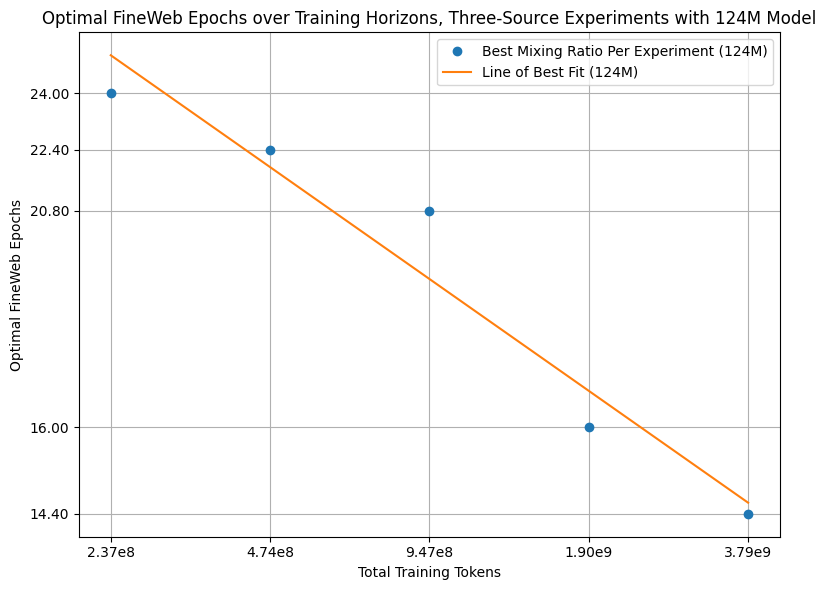

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter, FixedLocator, NullFormatter

fine_web = 32 * np.array([0.75, 0.70, 0.65, 0.50, 0.45])
horizons = np.array([
    7238 * 128 * 256,
    14480 * 128 * 256,
    28908 * 128 * 256,
    57842 * 128 * 256,
    115665 * 128 * 256
])

X = np.log(horizons).reshape(-1, 1)
y = np.log(fine_web)
reg = LinearRegression().fit(X, y)
x_line = np.linspace(horizons.min(), horizons.max(), 200)
y_line = np.exp(reg.predict(np.log(x_line).reshape(-1, 1)))

plt.figure(figsize=(8,6))
plt.plot(horizons, fine_web, 'o', label="Best Mixing Ratio Per Experiment (124M)")
plt.plot(x_line, y_line, '-', label="Line of Best Fit (124M)")

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

ax.xaxis.set_major_locator(FixedLocator(horizons))
ax.yaxis.set_major_locator(FixedLocator(fine_web))

ax.xaxis.set_minor_locator(FixedLocator([]))
ax.yaxis.set_minor_locator(FixedLocator([]))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

def sci_no_plus(x, _):
    s = f"{x:.2e}"
    base, exp = s.split("e")
    exp = str(int(exp))
    return f"{base}e{exp}"

ax.xaxis.set_major_formatter(FuncFormatter(sci_no_plus))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

plt.xlabel("Total Training Tokens")
plt.ylabel("Optimal FineWeb Epochs")
plt.legend()
plt.grid(True, which="major")
plt.title("Optimal FineWeb Epochs over Training Horizons, Three-Source Experiments with 124M Model")

plt.tight_layout()
plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# proportions → epochs
fine_web = np.array([0.75, 0.70, 0.65, 0.50, 0.45]) * 32
horizons = np.array([
    7238 * 128 * 256,
    14480 * 128 * 256,
    28908 * 128 * 256,
    57842 * 128 * 256,
    115665 * 128 * 256
])

target_horizon = 3.84e9

def fit_and_predict(horizons_subset, fine_web_subset, target):
    X = np.log(horizons_subset).reshape(-1, 1)
    y = np.log(fine_web_subset)
    reg = LinearRegression().fit(X, y)
    pred_log = reg.predict([[np.log(target)]])
    return float(np.exp(pred_log)), reg

# First 2 points
pred_2, reg2 = fit_and_predict(horizons[:2], fine_web[:2], target_horizon)

# First 3 points
pred_3, reg3 = fit_and_predict(horizons[:3], fine_web[:3], target_horizon)

print(f"Prediction using first 2 points: epochs ≈ {pred_2:.2f}")
print(f"Prediction using first 3 points: epochs ≈ {pred_3:.2f}")


Prediction using first 2 points: epochs ≈ 18.19
Prediction using first 3 points: epochs ≈ 18.02


/tmp/ipykernel_3422978/592075038.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.exp(pred_log)), reg
/tmp/ipykernel_3422978/592075038.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.exp(pred_log)), reg


In [41]:
""" # Plotting the previous prediction
plt.figure(figsize=(8,6))
plt.scatter(horizons, fine_web, c="black", label="data")

x_line = np.linspace(horizons.min(), horizons.max(), 200)
plt.plot(x_line, np.exp(reg2.predict(np.log(x_line).reshape(-1,1))),
         "--", label="fit (first 2)")
plt.plot(x_line, np.exp(reg3.predict(np.log(x_line).reshape(-1,1))),
         "-.", label="fit (first 3)")

plt.axvline(target_horizon, color="gray", ls=":")
plt.scatter([target_horizon], [pred_2], c="blue", marker="x", s=100, label=f"pred (2 pts) = {pred_2:.2f}")
plt.scatter([target_horizon], [pred_3], c="red", marker="x", s=100, label=f"pred (3 pts) = {pred_3:.2f}")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training Horizon (tokens)")
plt.ylabel("Optimal FineWeb Epochs")
plt.legend()
plt.grid(True, which="major")
plt.tight_layout()
plt.show()"""

' # Plotting the previous prediction\nplt.figure(figsize=(8,6))\nplt.scatter(horizons, fine_web, c="black", label="data")\n\nx_line = np.linspace(horizons.min(), horizons.max(), 200)\nplt.plot(x_line, np.exp(reg2.predict(np.log(x_line).reshape(-1,1))),\n         "--", label="fit (first 2)")\nplt.plot(x_line, np.exp(reg3.predict(np.log(x_line).reshape(-1,1))),\n         "-.", label="fit (first 3)")\n\nplt.axvline(target_horizon, color="gray", ls=":")\nplt.scatter([target_horizon], [pred_2], c="blue", marker="x", s=100, label=f"pred (2 pts) = {pred_2:.2f}")\nplt.scatter([target_horizon], [pred_3], c="red", marker="x", s=100, label=f"pred (3 pts) = {pred_3:.2f}")\n\nplt.xscale("log")\nplt.yscale("log")\nplt.xlabel("Training Horizon (tokens)")\nplt.ylabel("Optimal FineWeb Epochs")\nplt.legend()\nplt.grid(True, which="major")\nplt.tight_layout()\nplt.show()'

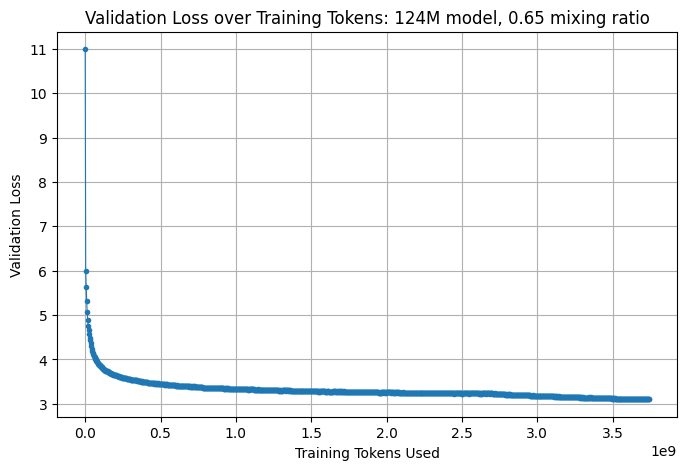

In [42]:
# Loss Curve for 2 source experiments, 124M Model
import re
import matplotlib.pyplot as plt
model_size = "124M"
mixture = "0.65"
# log file
log_file = f"logs/wikipedia/114142iters/mix{mixture}_lr0.001_{model_size}_1/train.log"

tokens = []
val_losses = []

# getting the step and val loss
pattern = re.compile(r"step:(\d+)/\d+.*?val_loss:([\d\.]+)")

with open(log_file, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            step = int(match.group(1))
            val_loss = float(match.group(2))
            tokens.append(128 * 256 * step)
            val_losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(tokens, val_losses, marker="o", linestyle="-", linewidth=0.8, markersize=3)
plt.xlabel("Training Tokens Used")
plt.ylabel("Validation Loss")
plt.title(f"Validation Loss over Training Tokens: {model_size} model, {mixture} mixing ratio")
plt.grid(True)
plt.show()

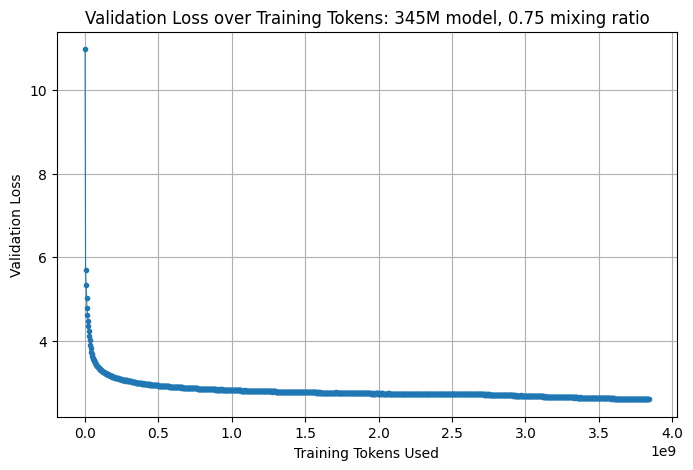

In [43]:
# Loss Curve for 2 source experiments, 345M model
import re
import matplotlib.pyplot as plt
model_size = "345M"
mixture = "0.75"
# log file
log_file = f"logs/pubmed/117188iters/mix{mixture}_lr0.001_{model_size}_1/train.log"

tokens = []
val_losses = []

# getting the step and val loss
pattern = re.compile(r"step:(\d+)/\d+.*?val_loss:([\d\.]+)")

with open(log_file, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            step = int(match.group(1))
            val_loss = float(match.group(2))
            tokens.append(128 * 256 * step)
            val_losses.append(val_loss)

plt.figure(figsize=(8,5))
plt.plot(tokens, val_losses, marker="o", linestyle="-", linewidth=0.8, markersize=3)
plt.xlabel("Training Tokens Used")
plt.ylabel("Validation Loss")
plt.title(f"Validation Loss over Training Tokens: {model_size} model, {mixture} mixing ratio")
plt.grid(True)
plt.show()

In [44]:
# The code below is for storage and archiving purposes. 
# This code was primarily used in the early stages of the project and either became refactored into general functions or is no longer used.

Dataframe for 2x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00100,3.5000,33.1152
1,0.80,0.00100,3.3172,27.5829
2,0.85,0.00100,3.2481,25.7426
3,0.90,0.00141,3.2718,26.3600


Dataframe for 4x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00141,3.2026,24.5961
1,0.80,0.00100,3.0963,22.1168
2,0.85,0.00200,3.0706,21.5541
3,0.90,0.00141,3.1211,22.6720


Dataframe for 8x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00141,2.9454,19.0185
1,0.80,0.00100,2.9152,18.4527
2,0.85,0.00141,2.9268,18.6677
3,0.90,0.00100,2.9916,19.9183


Dataframe for 16x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.70,0.00141,2.8017,16.4721
1,0.75,0.00141,2.7807,16.1304
2,0.80,0.00100,2.7922,16.3168
3,0.85,0.00141,2.8255,16.8698


Dataframe for 32x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,2.7425,15.5258
1,0.60,0.001,2.6804,14.5914
2,0.65,0.001,2.6645,14.3602
3,0.70,0.001,2.6701,14.4409
4,0.75,0.001,2.6808,14.5973
5,0.80,0.001,2.7063,14.9736
6,0.85,0.001,2.7440,15.5493
7,0.90,0.001,2.8232,16.8306


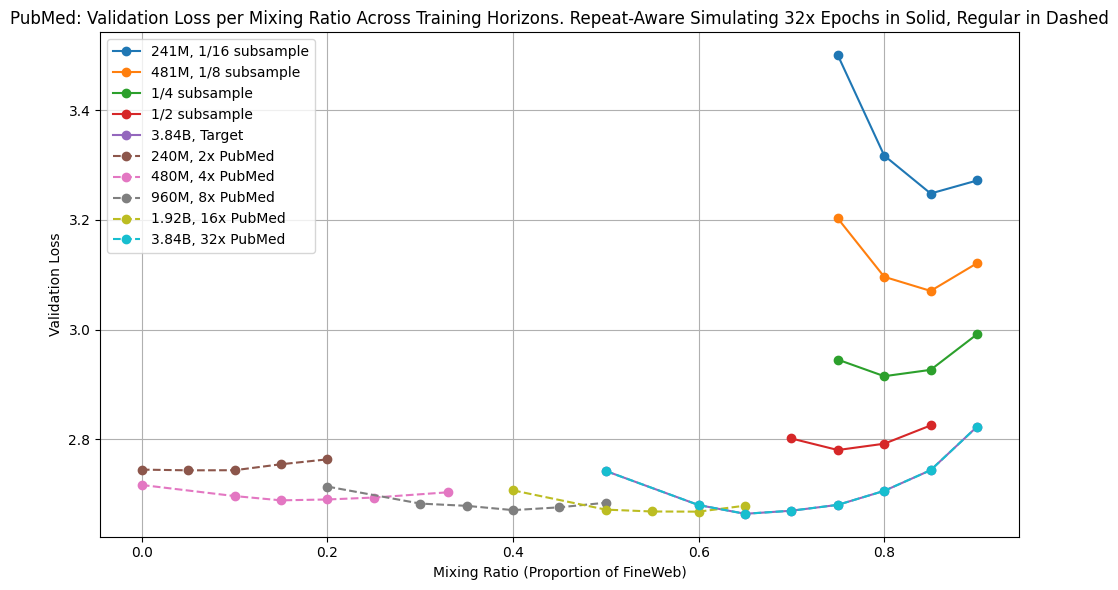

In [45]:
from scipy.special import logit
# repeat aware 
iter_values = [7366, 14679, 29249, 58566, 117188]
file_paths = []
model_params = ["124M"]
subsamples = [16, 8, 4, 2, 1]
for model in model_params:
    for i in range(len(iter_values)):
        file_paths.append(f"./summary_logs/pubmed/summary_{iter_values[i]}iter_{model}_{subsamples[i]}.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
pubmed_tokens = [2,4,8,16,32]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "1/4 subsample", "1/2 subsample", "3.84B, Target"]
dfs = best_runs(file_paths, pubmed_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x PubMed")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


# 
# plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
file_paths_reg = []
pubmed_tokens = [2, 4, 8, 16, 32]
model_params = ["124M"]
legend_idx = 0
for model in model_params:
    for val in iter_values_reg:
        file_paths_reg.append(f"./summary_logs/pubmed/summary_{val}iter_{model}_1.txt")
        
dfs_reg = best_runs(file_paths_reg, pubmed_tokens)  
for df in dfs_reg:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels_reg[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("PubMed: Validation Loss per Mixing Ratio Across Training Horizons. Repeat-Aware Simulating 32x Epochs in Solid, Regular in Dashed")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

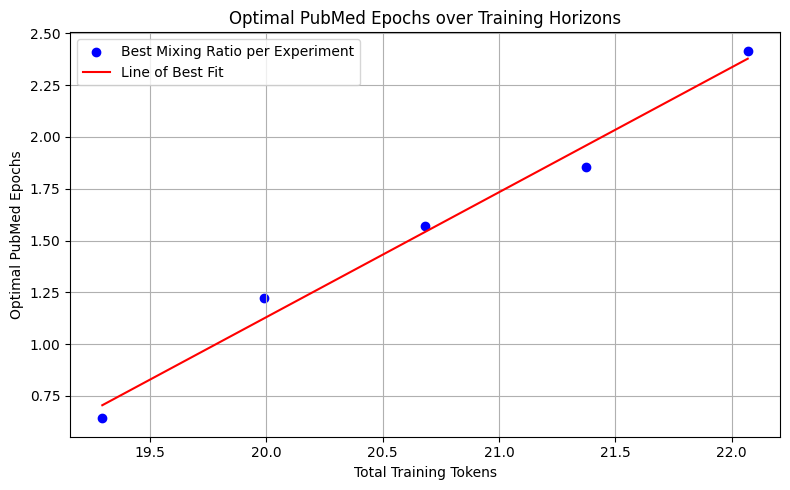

In [46]:
# Logistic Regression, multiply the mixing ratio by the number of wikipedia tokens to get the epochs of Wikipedia 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

df_best = get_best_overall_runs(file_paths_reg, pubmed_tokens)
df_best["experiment"] = df_best["experiment"].astype(float)

df_best["optimal_pubmed_epochs"] = df_best["experiment"] * (1 - df_best["mixing_ratio"])
df_best["tokens"] = (df_best["experiment"] * 120000060)
# df_best["log_wiki_epochs"] = np.log(df_best["wiki_epochs"])

# X = wiki_epochs, y = optimal mixing_ratio
X = (np.log(df_best[["tokens"]].values))
y = (np.log(df_best["optimal_pubmed_epochs"].values))

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X, y)

import matplotlib.pyplot as plt
x_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = reg.predict(x_test)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", label="Best Mixing Ratio per Experiment")
plt.plot(x_test, y_pred, color="red", label="Line of Best Fit")
plt.xlabel("Total Training Tokens")

plt.ylabel("Optimal PubMed Epochs")
plt.title("Optimal PubMed Epochs over Training Horizons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wikipedia usually considered ~ highest quality 
# do repeat scaling laws for lower quality domains
# fineweb edu

Dataframe for 2x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.67,0.00100,4.8396,126.4173
1,0.75,0.00100,4.0409,56.8758
2,0.80,0.00100,3.8343,46.2621
3,0.85,0.00141,3.7429,42.2213
4,0.90,0.00141,3.7537,42.6775
5,0.95,0.00100,3.8568,47.3147
6,0.99,0.00100,4.0233,55.8844


Dataframe for 4x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.67,0.001,4.1442,63.0675
1,0.75,0.001,3.6819,39.7220
2,0.80,0.001,3.5749,35.6917
3,0.85,0.001,3.5464,34.6899
4,0.90,0.001,3.5842,36.0232


Dataframe for 8x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.001,3.8923,49.0241
1,0.67,0.001,3.5972,36.4962
2,0.75,0.001,3.4114,30.3085
3,0.80,0.001,3.3711,29.1108
4,0.85,0.001,3.3868,29.5713
5,0.90,0.001,3.4442,31.3182


Dataframe for 16x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.00100,3.3940,29.7861
1,0.70,0.00141,3.2448,25.6575
2,0.75,0.00141,3.2275,25.2171
3,0.80,0.00100,3.2299,25.2762
4,0.85,0.00100,3.2638,26.1485


Dataframe for 32x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.001,3.1227,22.7067
1,0.65,0.001,3.1027,22.2570
2,0.70,0.001,3.1029,22.2627
3,0.75,0.001,3.1127,22.4818
4,0.80,0.001,3.1425,23.1621
5,0.85,0.001,3.1800,24.0465
6,0.90,0.001,3.2545,25.9059


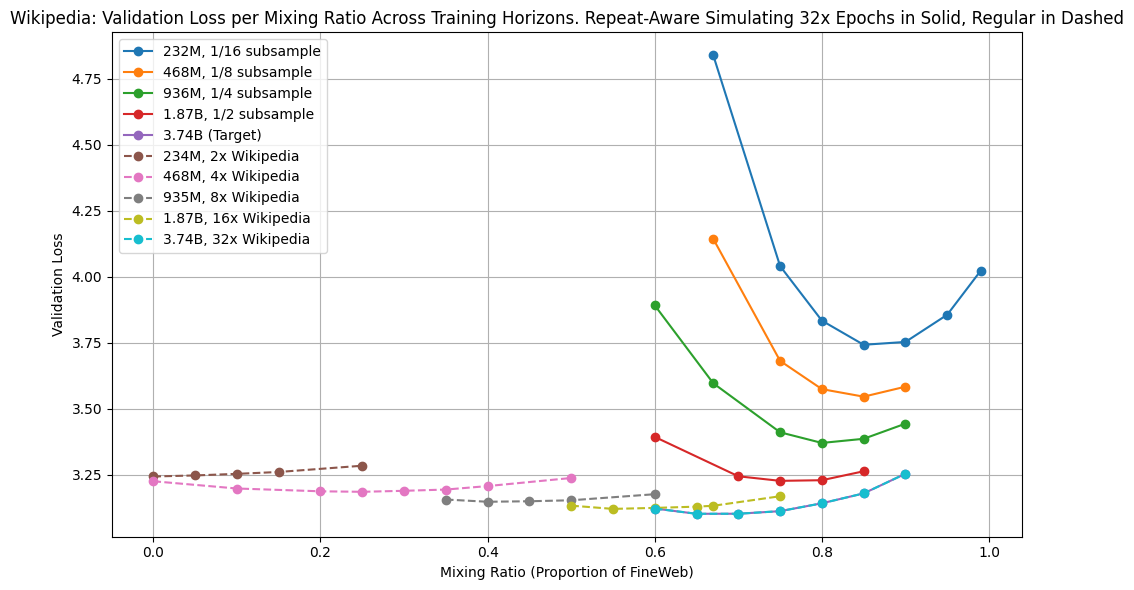

In [47]:
# Old Plotting Code
from scipy.special import logit
iter_values = [7110, 14280, 28566, 57118, 114142]
file_paths = []
model_params = ["124M"]
subsamples = [16, 8, 4, 2, 1]
for model in model_params:
    for i in range(len(iter_values)):
        file_paths.append(f"./summary_logs/wikipedia/summary_{iter_values[i]}iter_{model}_{subsamples[i]}.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
wiki_tokens = [2,4,8,16,32]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
dfs = best_runs(file_paths, wiki_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


# 
# plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)
legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
file_paths_reg = []
model_params = ["124M"]
legend_idx = 0
for model in model_params:
    for val in iter_values_reg:
        file_paths_reg.append(f"./summary_logs/wikipedia/summary_{val}iter_{model}_1.txt")
        
dfs_reg = best_runs(file_paths_reg, wiki_tokens)  
for df in dfs_reg:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels_reg[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("Wikipedia: Validation Loss per Mixing Ratio Across Training Horizons. Repeat-Aware Simulating 32x Epochs in Solid, Regular in Dashed")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Dataframe for 2x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00200,3.2440,25.6353
1,0.05,0.00141,3.2480,25.7389
2,0.10,0.00141,3.2540,25.8930
3,0.15,0.00200,3.2611,26.0791
4,0.25,0.00141,3.2848,26.7034


Dataframe for 4x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00141,3.2260,25.1783
1,0.10,0.00141,3.1985,24.4963
2,0.20,0.00141,3.1879,24.2386
3,0.25,0.00200,3.1860,24.1919
4,0.30,0.00141,3.1898,24.2839
5,0.35,0.00141,3.1945,24.3989
6,0.40,0.00141,3.2077,24.7222
7,0.50,0.00141,3.2383,25.4892


Dataframe for 8x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.35,0.00100,3.1567,23.4922
1,0.40,0.00141,3.1483,23.2967
2,0.45,0.00141,3.1502,23.3401
3,0.50,0.00141,3.1539,23.4262
4,0.60,0.00141,3.1769,23.9722


Dataframe for 16x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,3.1336,22.9574
1,0.55,0.001,3.1213,22.6757
2,0.60,0.001,3.1250,22.7601
3,0.65,0.001,3.1298,22.8691
4,0.67,0.001,3.1331,22.9452
5,0.75,0.001,3.1692,23.7883


Dataframe for 32x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.001,3.1227,22.7067
1,0.65,0.001,3.1027,22.2570
2,0.70,0.001,3.1029,22.2627
3,0.75,0.001,3.1127,22.4818
4,0.80,0.001,3.1425,23.1621
5,0.85,0.001,3.1800,24.0465
6,0.90,0.001,3.2545,25.9059


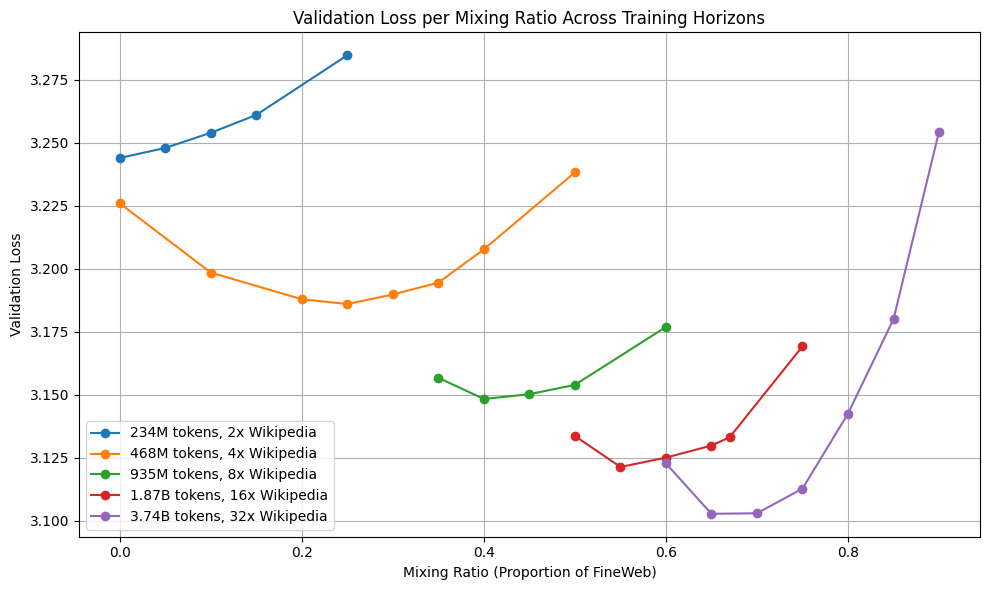

In [48]:
from scipy.special import logit
iter_values = [7134, 14268, 28536, 57071, 114142]
file_paths = []
model_params = ["124M"]
for model in model_params:
    for val in iter_values:
        file_paths.append(f"./summary_logs/wikipedia/summary_{val}iter_{model}_1.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
wiki_tokens = [2,4,8,16,32]
legend_labels = ["234M", "468M", "935M", "1.87B", "3.74B"]
dfs = best_runs(file_paths, wiki_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]} tokens, {label}x Wikipedia"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Mixing Ratio Across Training Horizons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# bracket between the previous best learning rate and 1/2 the prev best learning rate?